In [2]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/__init__.py:96: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:37: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import _minimize_lbfgsb


## setup

In [3]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

In [41]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions']

# which iteration name should we use?
iterationName = 'run4_generalization'

In [72]:
## get total number of stroke and clickedObj events in the collection as a whole
S = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.' # previously 722 so 882 ideally 

7935 stroke records in the database.
1443 clickedObj records in the database.


In [73]:
# ## checking to see if certain workers submitted data 
# S = coll.find({ '$and': [{'eventType': 'stroke'},{'workerID': 'A1V2P0JYPD7GM6'}]}).sort('time')
# C = coll.find({ '$and': [{'eventType': 'clickedObj'},{'workerID': 'A1V2P0JYPD7GM6'}]}).sort('time')
# print str(S.count()) + ' stroke records in the database.'
# print str(C.count()) + ' clickedObj records in the database.'

## generate group dataframe

In [74]:
## list of researcher mturk worker ID's to ignore
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
megsano = ['A1DVQQLVZR7W6I']
researchers = jefan + hawkrobe + megsano 

In [75]:
reload(h)
## get list of all candidate games
games = coll.distinct('gameid')

## get list of complete and valid games
_complete_games = h.get_complete_and_valid_games(games,coll,iterationName,researchers=researchers, tolerate_undefined_worker=False)

There are 35 complete games in total.


In [76]:
# len(_complete_games)

In [87]:
reload(h)

# preprocessing 

TrialNum = []
GameID = []
Condition = []
Target = []
Category = []
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
Repetition = []
Phase = []
numStrokes = []
drawDuration = [] # in seconds
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = [] #accuracy (True or False)
png=[] # the sketch 
timedOut=[] # True if sketchers didn't draw anything, False o.w.
meanPixelIntensity=[]

y = ['3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a']
_complete_games= [item for item in _complete_games if item not in y]
for i,g in enumerate(_complete_games):
        print 'Analyzing game {} | {} of {}: '.format(g, i, len(_complete_games))

        # collection of all clickedObj events in a particular game 
        X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
        # collection of all stroke events in a particular game 
        Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')

        for t in X: # for each clickedObj event
            targetname = t['intendedName']
            category = h.OBJECT_TO_CATEGORY_run2[targetname]
            Phase.append(t['phase'])
            Repetition.append(t['repetition'])
            distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
            full_list = [t['intendedName'],t['object2Name'],t['object3Name'],t['object4Name']] 
            png.append(t['pngString'])

            #for each stroke event with same trial number as this particular clickedObj event 
            y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
            # have to account for cases in which sketchers do not draw anything 
            if (y.count() == 0):
                numStrokes.append(float('NaN'))
                drawDuration.append(float('NaN'))
                svgStringLength.append(float('NaN'))
                svgStringLengthPerStroke.append(float('NaN'))
                numCurvesPerSketch.append(float('NaN'))
                numCurvesPerStroke.append(float('NaN'))
                svgStringStd.append(float('NaN'))
                meanPixelIntensity.append('NaN')
                timedOut.append(True)
            else: 
                y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
                lastStrokeNum = float(y[y.count() - 1]['currStrokeNum']) # get currStrokeNum at last stroke
                ns = y.count()
                if not lastStrokeNum == ns:
                    print "ns: " + str(ns)
                    print "lastStrokeNum: " + str(lastStrokeNum)
                
                #assert lastStrokeNum == ns
                numStrokes.append(lastStrokeNum)
                
                # calculate drawDuration 
                startStrokeTime =  float(y[0]['startStrokeTime'])
                endStrokeTime = float(y[y.count() - 1]['endStrokeTime']) ## took out negative 1 
                duration = (endStrokeTime - startStrokeTime) / 1000
                drawDuration.append(duration)
                
                # calculate other measures that have to do with sketch 
                ls = [len(_y['svgData']) for _y in y]
                svgStringLength.append(sum(ls))
                y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')            
                num_curves = [len([m.start() for m in re.finditer('c',str(_y['svgData']))]) for _y in y] ## gotcha: need to call string on _y['svgData'], o/w its unicode and re cant do anything with it
                numCurvesPerSketch.append(sum(num_curves))
                numCurvesPerStroke.append(sum(num_curves)/lastStrokeNum)
                svgStringLengthPerStroke.append(sum(ls)/lastStrokeNum)
                svgStringStd.append(np.std(ls))
                timedOut.append(False)
                
                ## calculate pixel intensity (amount of ink spilled) 
            
                imsize = 100
                numpix = imsize**2
                thresh = 250
                imgData = t['pngString']
                filestr = base64.b64decode(imgData)
                fname = os.path.join('sketch.png')
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))
                im = Image.open(fname).resize((imsize,imsize))
                _im = np.array(im)
                meanPixelIntensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)

            ### aggregate game metadata
            TrialNum.append(t['trialNum'])
            GameID.append(t['gameid'])        
            Target.append(targetname)
            Category.append(category)
            Condition.append(t['condition'])
            Response.append(t['clickedName'])
            Outcome.append(t['correct'])
            Distractor1.append(distractors[0])
            Distractor2.append(distractors[1])
            Distractor3.append(distractors[2])  

Analyzing game 0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b | 0 of 34: 
Analyzing game 8705-4970135a-e63c-4cd1-953f-d5850978a781 | 1 of 34: 
Analyzing game 0051-e13f6f0c-ae9b-4976-8fcd-870cdb75f63f | 2 of 34: 
Analyzing game 9790-3a0dd9df-cae0-4f97-95b4-93bf1d0bfd09 | 3 of 34: 
Analyzing game 9289-9e66fe1c-fc3d-4fc3-868f-ac6a2c7def6e | 4 of 34: 
Analyzing game 0786-9d8492b6-e57d-4cb6-a44e-a79bccb681f4 | 5 of 34: 
Analyzing game 5598-e6b25d85-7c51-49f0-9529-c4c42d15b233 | 6 of 34: 
Analyzing game 6378-75ca9ee2-ed38-4434-b0bc-00c039f29b57 | 7 of 34: 
Analyzing game 7940-e30c3a20-dd99-4efc-ae92-f650a7f1d6e6 | 8 of 34: 
ns: 7
lastStrokeNum: 6.0
Analyzing game 1696-c4c60e8e-a818-42cf-8cef-9b5466d277a3 | 9 of 34: 
Analyzing game 9662-69da656f-884a-416f-a492-59c9f6a13a34 | 10 of 34: 
Analyzing game 9329-3901b756-7cdb-4061-b8b3-41e6e2be20fd | 11 of 34: 
Analyzing game 2391-14c2ae6d-73d2-4e2a-b4e8-d9cdedbd393c | 12 of 34: 
Analyzing game 6540-741a0240-208a-46d6-8181-5858614f27c0 | 13 of 34: 
Analy

### svg rendering 

In [45]:
import svg_rendering_helpers as srh
reload(srh)

<module 'svg_rendering_helpers' from 'svg_rendering_helpers.py'>

In [46]:
from matplotlib.path import Path
import matplotlib.patches as patches

In [47]:
for i,g in enumerate(['3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a']):    ## just the first one
    image_recs = coll.find({'$and': [{'gameid':g}, {'eventType':'clickedObj'}]}).sort('time')    
    num_drawings = image_recs.count()
    if num_drawings > 3:
        print 'Great! Number of drawings made by this person: {}'.format(image_recs.count())        
        ### now try looping through all images made during this session and render out
        try:
            image_recs = coll.find({'$and': [{'gameid':g}, {'eventType':'clickedObj'}]}).sort('time')    
            for imrec in image_recs:       
                ## now loop through all the strokes comprising this sketch 
                stroke_recs = coll.find({'$and': [
                                          {'gameid':g}, 
                                          {'eventType':'stroke'},
                                          {'trialNum': imrec['trialNum']}]}).sort('time')  
                ## check to make sure that there is at least one stroke! 
                assert stroke_recs.count()>0

                ## some handy metadata for writing out the sketch PNG filename
                trial_num = stroke_recs[0]['trialNum']
                
                category = (stroke_recs[0]['intendedName']).split("_")[0]
                game_id = stroke_recs[0]['gameid']

                ## now make an svg list!
                svg_list = srh.make_svg_list(stroke_recs)

                ## now get me some verts and codes!
                Verts, Codes = srh.get_verts_and_codes(svg_list)
 
                 ## now render out your cumulative sketches and save out as pngs!
                srh.render_and_save(Verts,
                                Codes,
                                line_width=5,
                                imsize=8,
                                canvas_size=600,
                                game_id=game_id,
                                trial_num=trial_num,
                                category=category)

        except Exception as e:
            print 'Oops, something went wrong! Here is the error:'  
            print e
            pass

Great! Number of drawings made by this person: 40
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/1_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_1_waiting_0.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/1_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_1_waiting_1.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/2_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_2_waiting_0.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/2_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_2_waiting_1.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/2_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_2_waiting_2.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/3_dining/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_3_dining_0.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/3_dining/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_3_dining_1.png
./cumulative_drawings/3601-542

./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/16_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_16_waiting_0.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/17_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_17_waiting_0.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/17_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_17_waiting_1.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/17_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_17_waiting_2.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/18_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_18_waiting_0.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/18_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_18_waiting_1.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/18_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_18_waiting_2.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679

./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/37_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_37_waiting_1.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/37_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_37_waiting_2.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/38_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_38_waiting_0.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/38_waiting/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_38_waiting_1.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/39_dining/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_39_dining_0.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/39_dining/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_39_dining_1.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/39_dining/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a_39_dining_2.png
./cumulative_drawings/3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a/39_d

In [133]:
## now actually make dataframe
GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity, svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png = map(np.array, \
[GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut,png])    

Repetition = map(int,Repetition)

D = pd.DataFrame([GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png], 
                 index = ['gameID','trialNum','condition', 'target', 'category', 'repetition', 'phase', 'drawDuration', 'outcome', 'response', 'numStrokes', 'meanPixelIntensity', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd', 'numCurvesPerSketch', 'numCurvesPerStroke', 'timedOut', 'png'])
D = D.transpose()

# filter out crazy games (low accuracy and timeouts)
accuracy_list = []
timed_outs = []

for g in _complete_games:
    D_ = D[D['gameID'] == g]
    all_accuracies = [d['outcome'] for i, d in D_.iterrows()]
    mean_accuracy = sum(all_accuracies) / float(len(all_accuracies))
    accuracy_list.append(mean_accuracy)
    if any(d['timedOut'] == True for i, d in D_.iterrows()):
        print "timed out!"
        timed_outs.append(g)
        
arr = np.array(accuracy_list)
med = np.median(arr)
sd = np.std(arr)
crazies = [i for i, acc in enumerate(accuracy_list) if (med-acc)/sd > 3]
crazy_games = [_complete_games[i] for i in crazies]
crazy_games = crazy_games + timed_outs
complete_games= [item for item in _complete_games if item not in crazy_games]                 
D = D.loc[D['gameID'].isin(complete_games)]

# save out dataframe to be able to load in and analyze later w/o doing the above mongo querying ...
D.to_csv(os.path.join(results_dir,'graphical_conventions_group_data_{}.csv'.format(iterationName)))

D_dining_repeated = D[(D['category'] == 'dining')& (D['condition'] == 'repeated')]
# Just look at one game 

D_dining_repeated.shape

(512, 19)

In [97]:
D_game = D[D['gameID'] == '3601-5426f18c-ab9f-40c9-b627-e4d09ce1679a'] # 5 repeateds and 3 controls??? 

In [109]:
D_dining_repeated = D[(D['category'] == 'waiting')& (D['condition'] == 'repeated')]
D_dining_repeated.shape

(576, 19)

In [111]:
arr = np.array(accuracy_list)
med = np.median(arr)
sd = np.std(arr)
print med, sd

0.875 0.117732046509


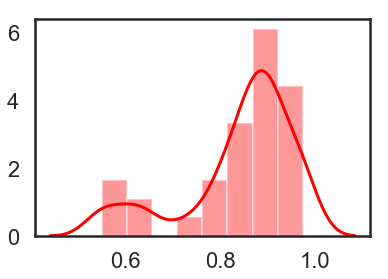

In [115]:
sns.distplot(accuracy_list, hist = True, color = "red")

##### normalizing dataframe for within-subjects analysis

In [134]:
# make copy of dataframe 
D_normalized = D.copy(deep = True)

In [140]:
D_correct = D[D['outcome'] == True]
D_correct_normalized = D_correct.copy(deep=True)

In [135]:
reload(h)
D_normalized = h.grand_mean_normalize(D_normalized, 'numStrokes', complete_games)
D_normalized = h.grand_mean_normalize(D_normalized, 'drawDuration', complete_games)
D_normalized = h.grand_mean_normalize(D_normalized, 'numCurvesPerSketch', complete_games)
D_normalized = h.grand_mean_normalize(D_normalized, 'meanPixelIntensity', complete_games)

In [141]:
D_correct_normalized = h.grand_mean_normalize(D_correct_normalized, 'numStrokes', complete_games)
D_correct_normalized = h.grand_mean_normalize(D_correct_normalized, 'drawDuration', complete_games)
D_correct_normalized = h.grand_mean_normalize(D_correct_normalized, 'numCurvesPerSketch', complete_games)
D_correct_normalized = h.grand_mean_normalize(D_correct_normalized, 'meanPixelIntensity', complete_games)

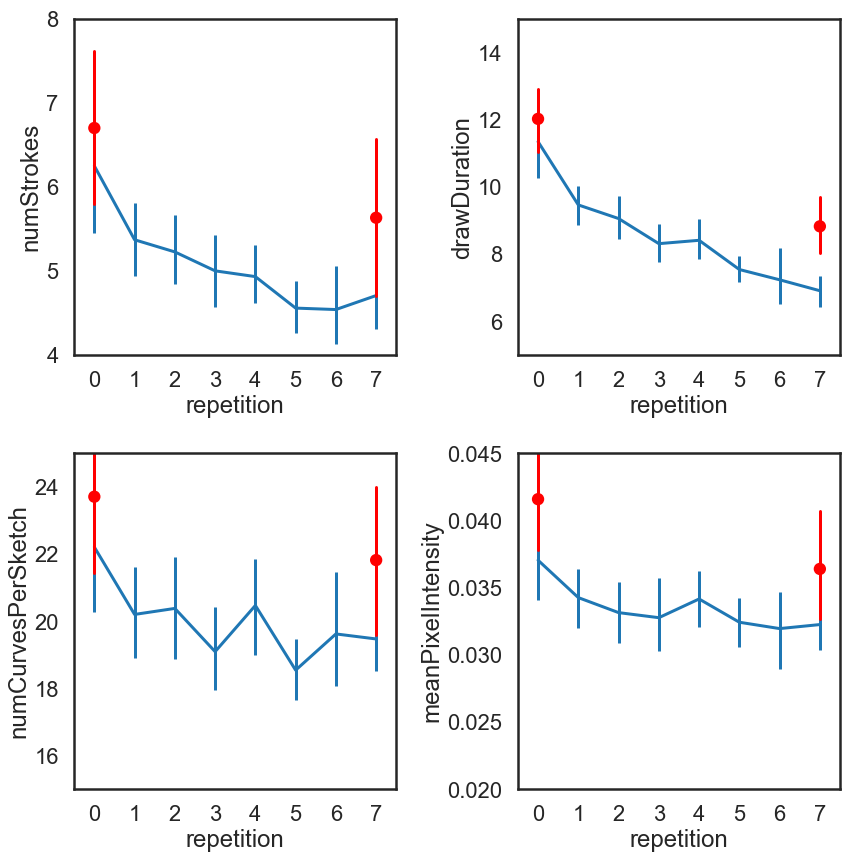

In [150]:
reload(h)
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3= 'meanPixelIntensity'
h.ts_grid_repeated_control(D_correct_normalized, 
                                                var0, var1, var2, var3,
                                                numReps=8,
                                                 save_plot=False,
                                                 plot_dir=plot_dir)

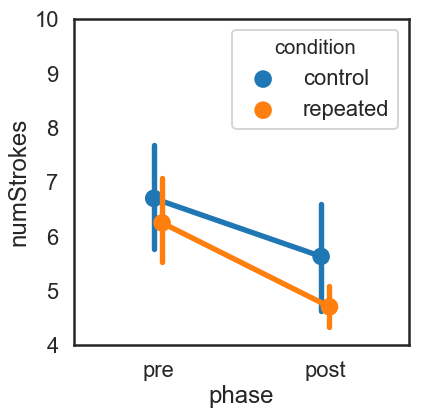

In [151]:
reload(h)
D1 = h.compare_conditions_prepost(D_correct_normalized,
                                var='numStrokes',
                                lower_limit = 4,
                                upper_limit=10,
                                save_plot=False,
                                plot_dir=plot_dir)

##### seeing how previous trial accuracy affects numStrokes in the current trial

In [12]:
falseNumStrokes = []
trueNumStrokes = []
for i, d in D.iterrows():
    if (i != D.shape[0] - 1):
        if d['outcome'] == False:
            nextNumStrokes = D['outcome'][i+1]
            falseNumStrokes.append(nextNumStrokes)
        else:
            nextNumStrokes = D['outcome'][i+1]
            trueNumStrokes.append(nextNumStrokes)
# meanNumStrokesGivenFalse = sum(falseNumStrokes)/float(len(falseNumStrokes))
# meanNumStrokesGivenTrue =  sum(trueNumStrokes)/float(len(trueNumStrokes))
# print meanNumStrokesGivenFalse, meanNumStrokesGivenTrue

## adding previous outcomes to each trial 
previousOutcome = []
previousOutcome.append('NaN')
for i, d in D.iterrows():
    if (i != D.shape[0] - 1):
        previousOutcome.append(d['outcome'])
D['previousOutcome'] = pd.Series(previousOutcome)

## conditioning on previous trial outcome being true 
D_true = D[D['previousOutcome'] == True]
reload(h)
dv = 'numStrokes'
h.ts_repeated_control(D_true, 
                        var=dv,
                        numReps = 6,
                        limit=10, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
                        save_plot=False,
                        plot_dir=plot_dir)

### confusion matrix for each category

In [108]:
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

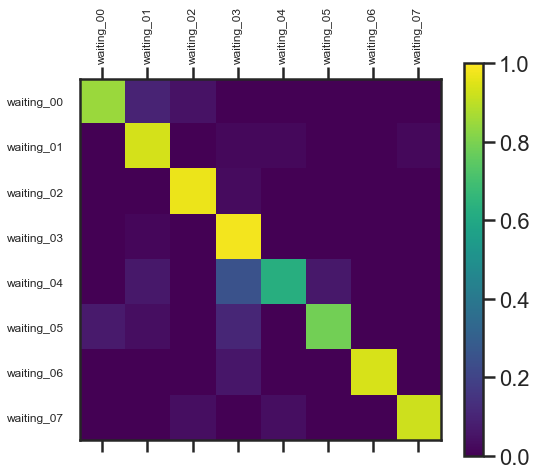

In [109]:
h.get_confusion_matrix(D, 'waiting', 4)

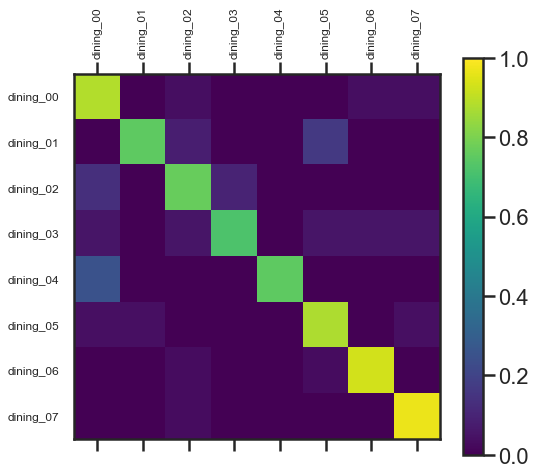

In [110]:
h.get_confusion_matrix(D, 'dining', 4)

##### confusion matrix for rep 0 and 7 

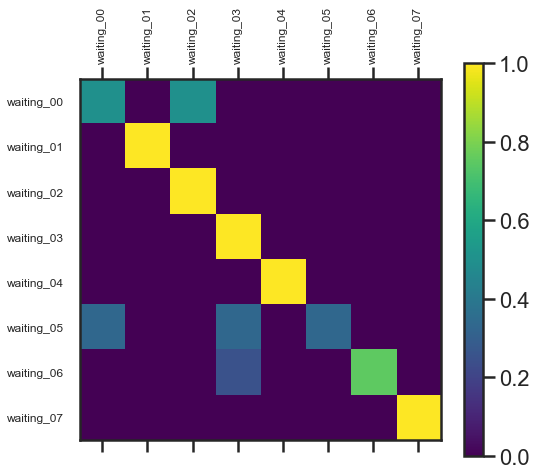

In [129]:
reload(h)
h.get_confusion_matrix_on_rep(D, 'waiting', 4, 0)

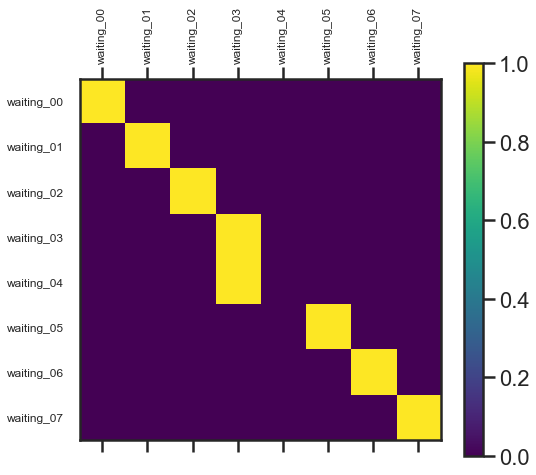

In [112]:
h.get_confusion_matrix_on_rep(D, 'waiting', 4, 7)

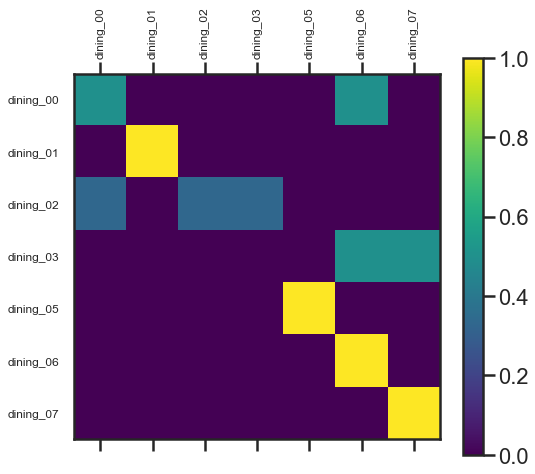

In [113]:
reload(h)
h.get_confusion_matrix_on_rep(D, 'dining', 4, 0)

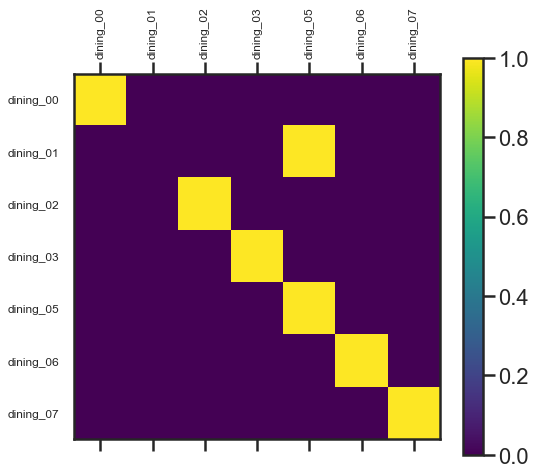

In [114]:
reload(h)
h.get_confusion_matrix_on_rep(D, 'dining', 4, 7)

## visualize behavioral measures over time

In [115]:
# reload analysis_helpers just to be on the safe side 
reload(h)

## set seaborn style params here
sns.set_context('poster')
sns.set_style('white')

##### Accuracy over time

In [100]:
total = 0
for outcome in D['outcome']:
    total = total + outcome 
meanAccuracy = total / len(D['outcome'])
meanAccuracy

0.84044117647058825

([<matplotlib.axis.XTick at 0x1a17c81950>,
 <a list of 8 Text xticklabel objects>)

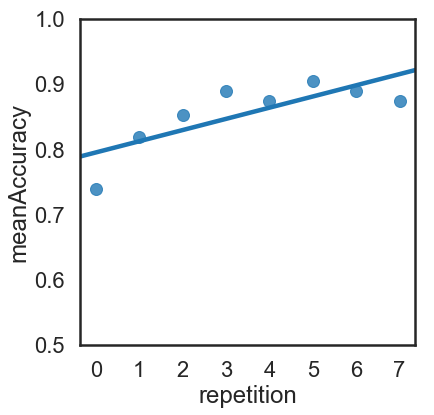

In [101]:
mean_accuracy_list = []
for i in range(0,8):
    outcome_list = (D.loc[D['repetition'] == i])['outcome']
    mean_accuracy = sum(outcome_list) / float(len(outcome_list))
    mean_accuracy_list.append(mean_accuracy)
D_mean = pd.DataFrame()
D_mean['meanAccuracy'] = mean_accuracy_list
D_mean['repetition'] = range(0,8)
D_mean
plt.figure(figsize=(6,6))
sns.regplot(data=D_mean,
         x='repetition',
         y='meanAccuracy',
         ci = None)    
plt.ylim([0.5,1.0])
plt.xticks(np.arange(0, 8, step=1))

### plot time series during repetition phase 

##### individual measures across reps (repeated + control)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


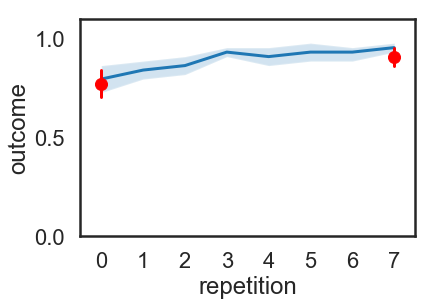

In [35]:
dv = 'numStrokes'
reload(h)
h.ts_repeated_control(D, 
                        var=dv,
                        numReps = 8,
                        limit=1.1, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
                        save_plot=False,
                        plot_dir=plot_dir)

##### 4 measures (2x2) across reps (repeated + control) 

In [120]:
# What are the four measures that you want to visualize across reps? 
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3= 'meanPixelIntensity'

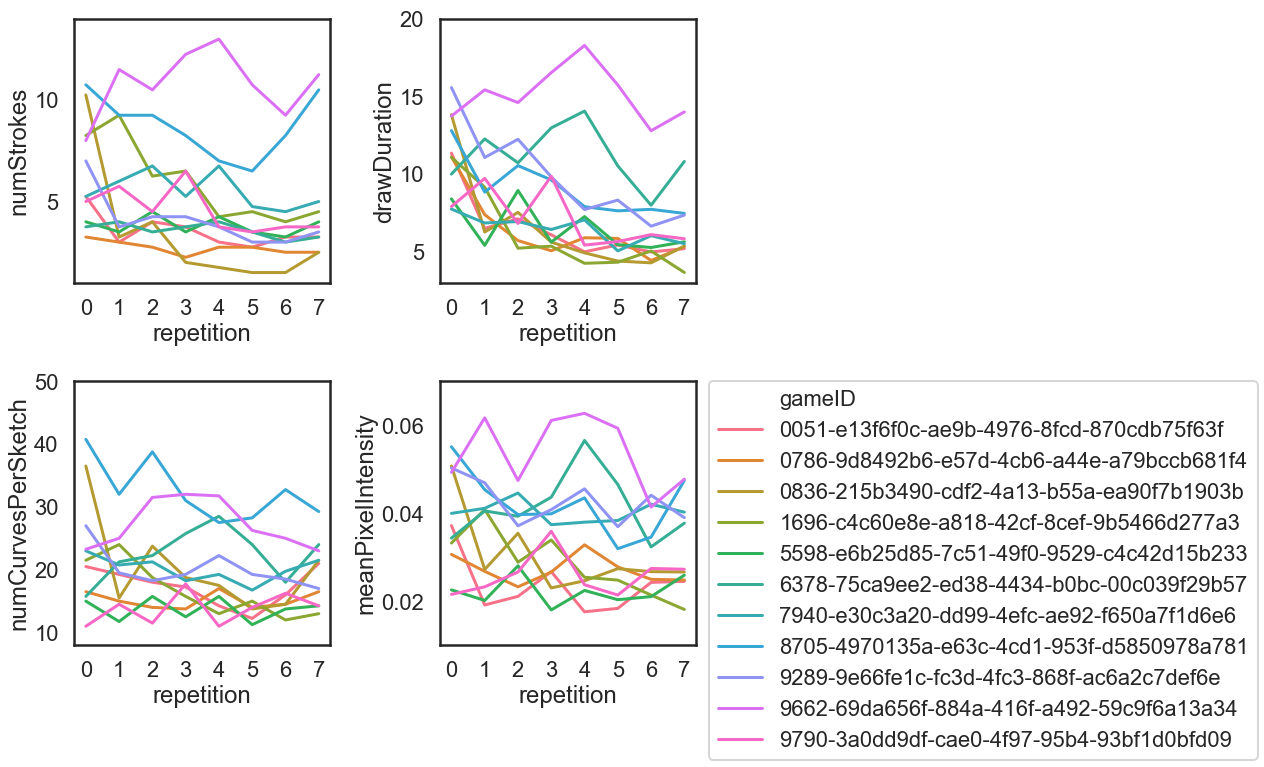

In [123]:
reload(h)
h.line_grid_individual(D, 
                                      var0, var1, var2, var3,
                                       numReps=8,
                                      save_plot=False,
                                      plot_dir=plot_dir)

In [94]:
# What are the four measures that you want to visualize across reps? 
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3= 'meanPixelIntensity'

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future

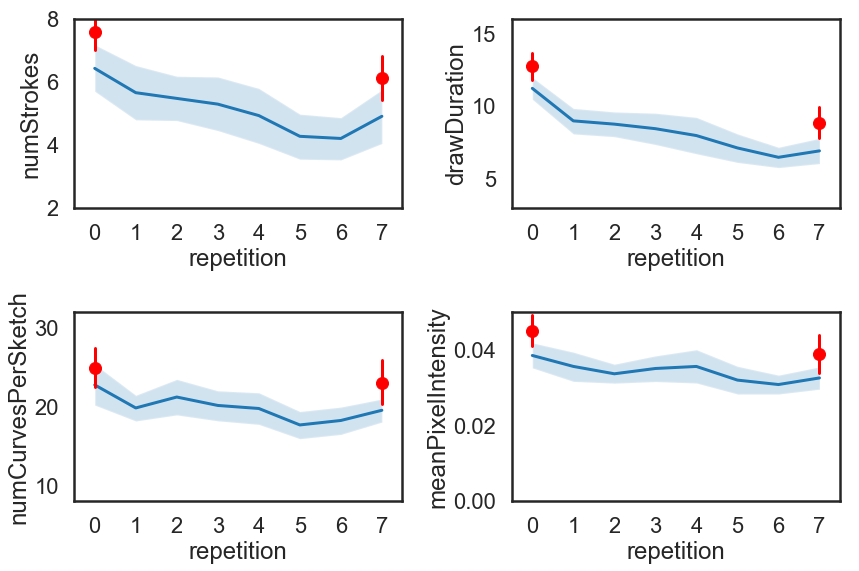

In [124]:
reload(h)
h.ts_grid_repeated_control(D, 
                                                var0, var1, var2, var3,
                                                numReps=8,
                                                 save_plot=False,
                                                 plot_dir=plot_dir)

### compare conditions in pre and post phases 

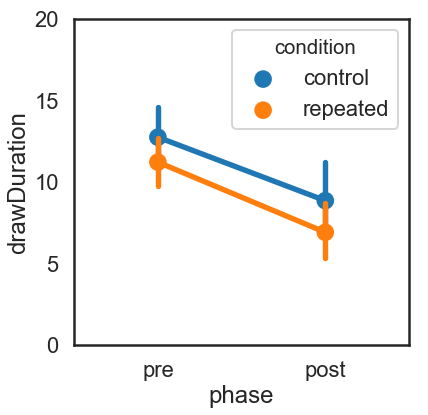

In [125]:
D1 = h.compare_conditions_prepost(D,
                                var='drawDuration',
                                limit=20,
                                save_plot=False,
                                plot_dir=plot_dir)

##### compare accuracy in pre and post phases (repeated vs control conditions)

In [127]:
for i, o in enumerate(D['outcome']):
    if o == True:
        D.set_value(i, 'outcome', 1)
    else:
        D.set_value(i, 'outcome', 0)
D['outcome'] = D['outcome'].astype(int)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 1.1)

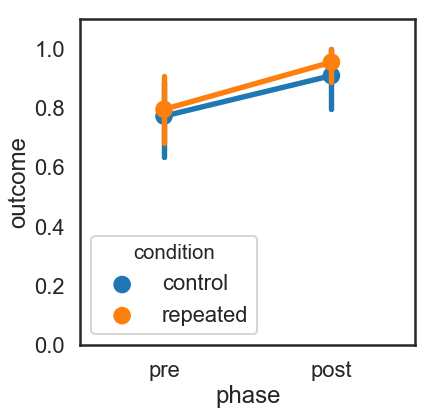

In [128]:
_D1 = D[D['phase']!='repeated'] ## exclude "repetition-phase" trials
D1 = _D1.groupby(['gameID','phase','condition'])['outcome'].mean()
D1 = D1.reset_index()    

plt.figure(figsize=(6,6))
sns.pointplot(data=D1,
         x='phase',
         y='outcome',
         hue='condition',
         order=['pre','post'])    
plt.ylim([0,1.1])
#plt.savefig(os.path.join(plot_dir,'timeseries_across_reps_{}.pdf'.format(var))) 
#return D1    

 ### visualize how sketches are changing across repetitions

##### printing actual sketches next to repeated sketches

Printing out sketches from game: 0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b
Printing out sketches from game: 8705-4970135a-e63c-4cd1-953f-d5850978a781
Printing out sketches from game: 0051-e13f6f0c-ae9b-4976-8fcd-870cdb75f63f
Printing out sketches from game: 9790-3a0dd9df-cae0-4f97-95b4-93bf1d0bfd09
Printing out sketches from game: 9289-9e66fe1c-fc3d-4fc3-868f-ac6a2c7def6e
Printing out sketches from game: 0786-9d8492b6-e57d-4cb6-a44e-a79bccb681f4
Printing out sketches from game: 5598-e6b25d85-7c51-49f0-9529-c4c42d15b233
Printing out sketches from game: 6378-75ca9ee2-ed38-4434-b0bc-00c039f29b57
Printing out sketches from game: 7940-e30c3a20-dd99-4efc-ae92-f650a7f1d6e6
Printing out sketches from game: 1696-c4c60e8e-a818-42cf-8cef-9b5466d277a3
Printing out sketches from game: 9662-69da656f-884a-416f-a492-59c9f6a13a34
Printing out sketches from game: 9329-3901b756-7cdb-4061-b8b3-41e6e2be20fd
Printing out sketches from game: 2391-14c2ae6d-73d2-4e2a-b4e8-d9cdedbd393c
Printing out sketches fro

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Printing out sketches from game: 1096-f9380acb-8b85-4f77-8d5a-c20189a77eba
Printing out sketches from game: 0955-60582965-41c6-492d-aa67-98e15630db39
Printing out sketches from game: 6333-9ef157b9-68ab-438e-bb27-f588abc2c906
Printing out sketches from game: 9769-9f38f477-8dbd-4976-96fa-d359b0d05222
Printing out sketches from game: 4197-1d23a6c0-9864-4a7f-a63d-558ef64cbf94
Printing out sketches from game: 4485-b6b989b0-c8f7-4a76-b133-3f2c4301e9f1
Printing out sketches from game: 4086-fdeecc93-f5a6-426f-a924-c53ebaf80069
Printing out sketches from game: 0050-769c4742-aefc-4bea-aeb2-7dc48b51fe82
Printing out sketches from game: 1456-d61538b0-dfa4-4429-bd74-42ce8c65ed4d
Printing out sketches from game: 9338-3d6dc953-6aca-48c1-b949-4e5491d3b967
Printing out sketches from game: 0647-0ece0513-aa05-4676-bb63-3845126ce2c1
Printing out sketches from game: 1993-b2fda10b-f02f-4ef8-a2f3-e482ead74bb9
Printing out sketches from game: 6725-7351d615-c816-4608-8554-afecf47c4b42


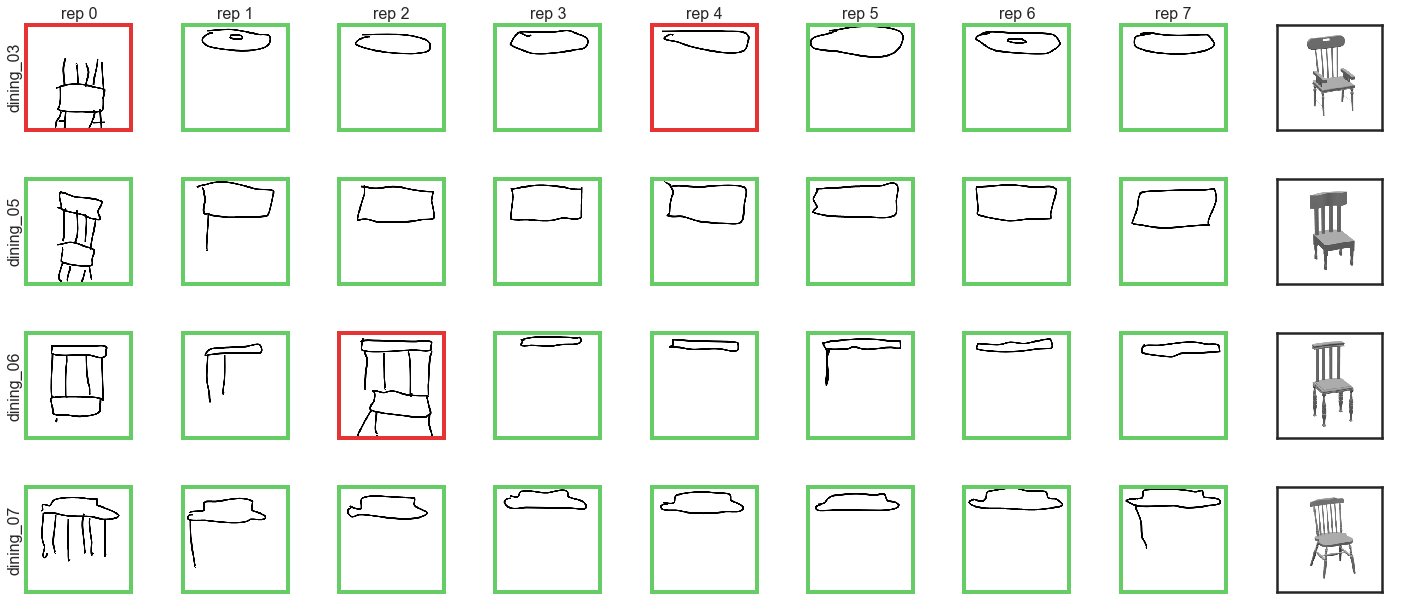

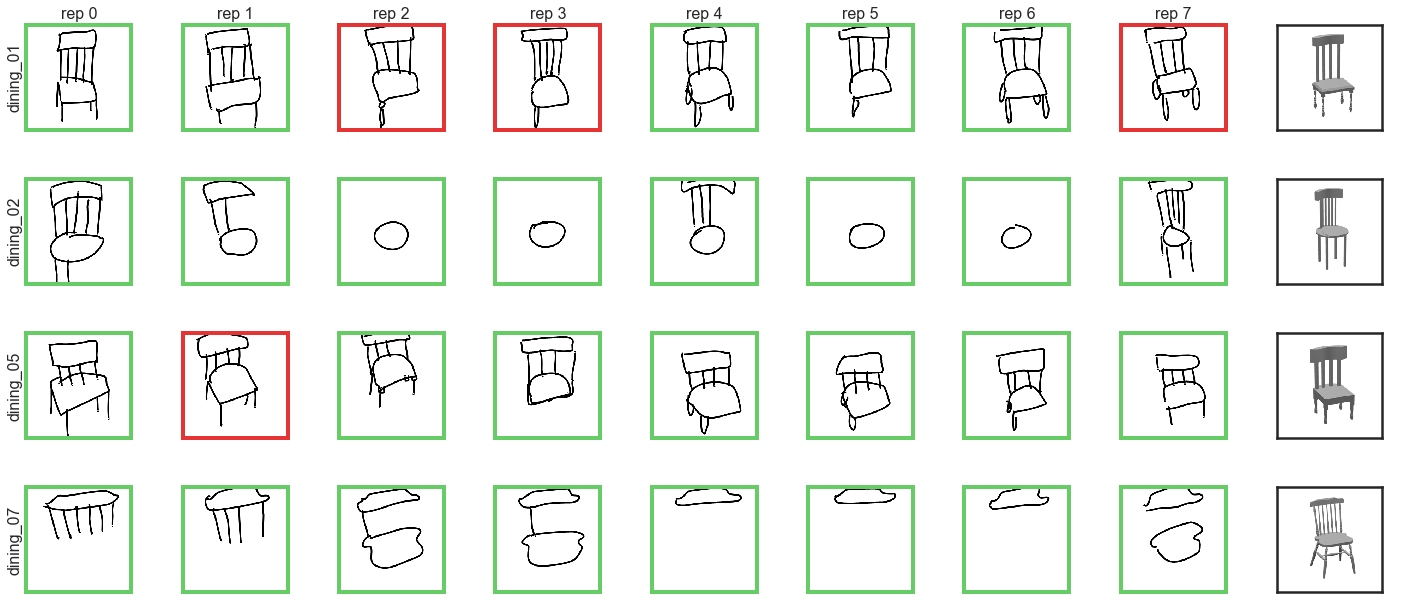

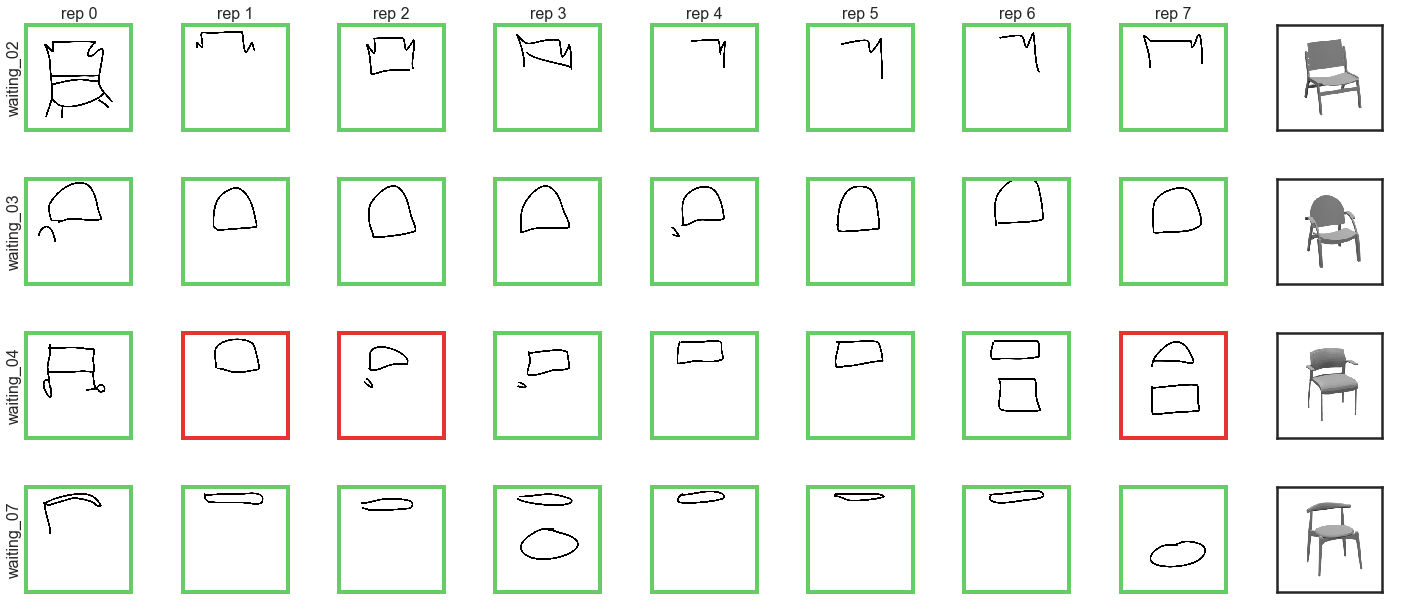

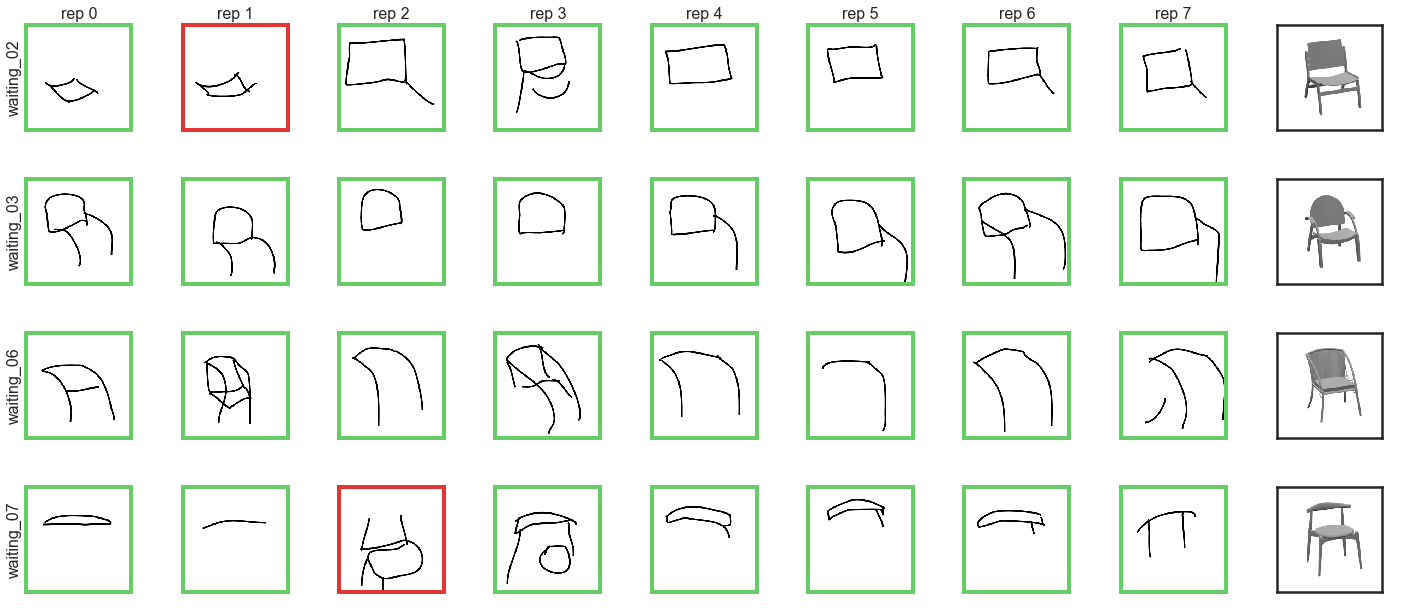

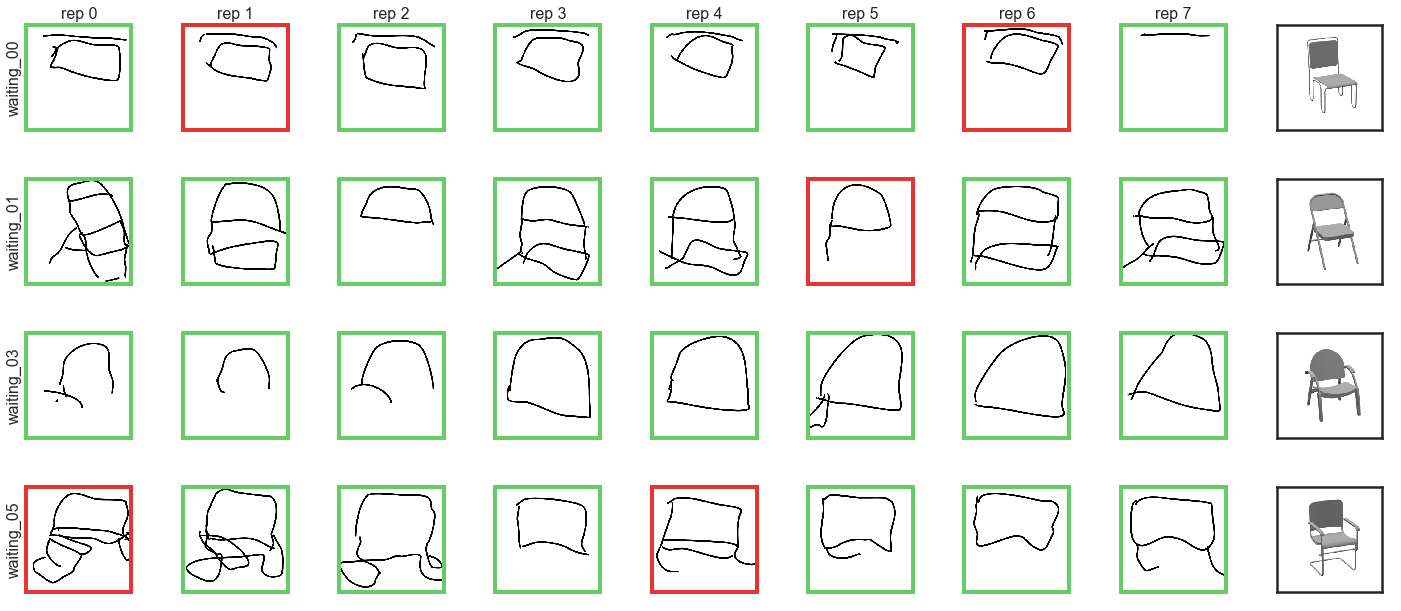

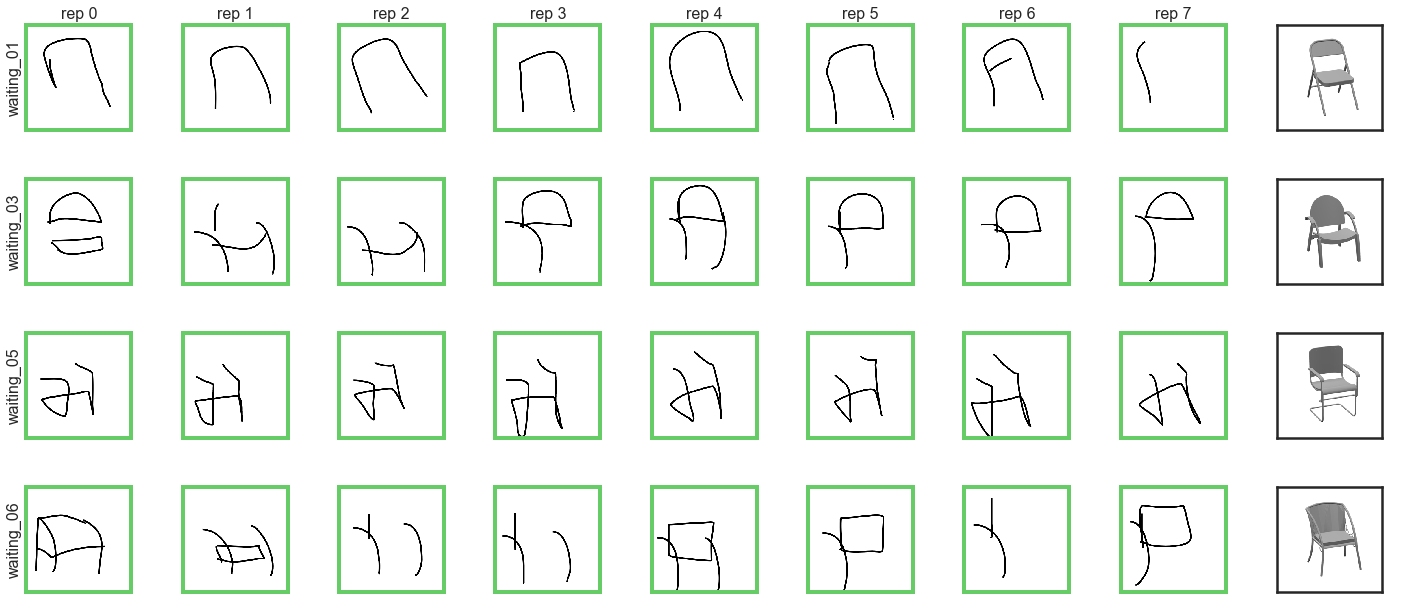

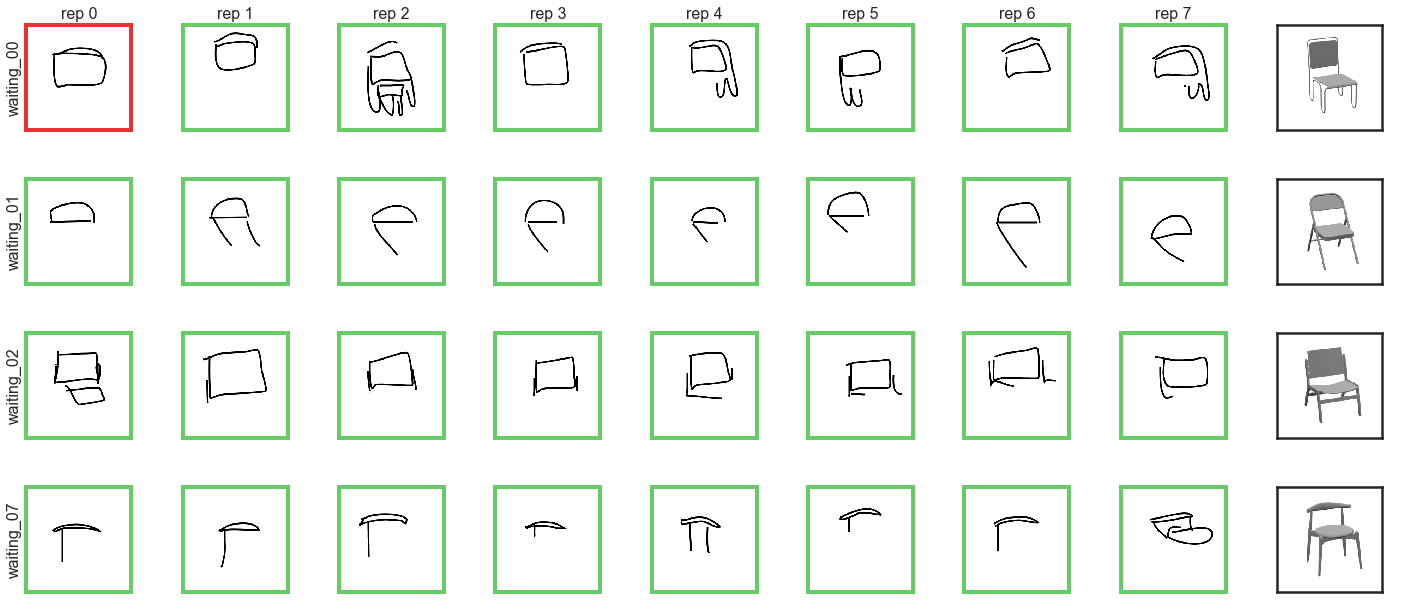

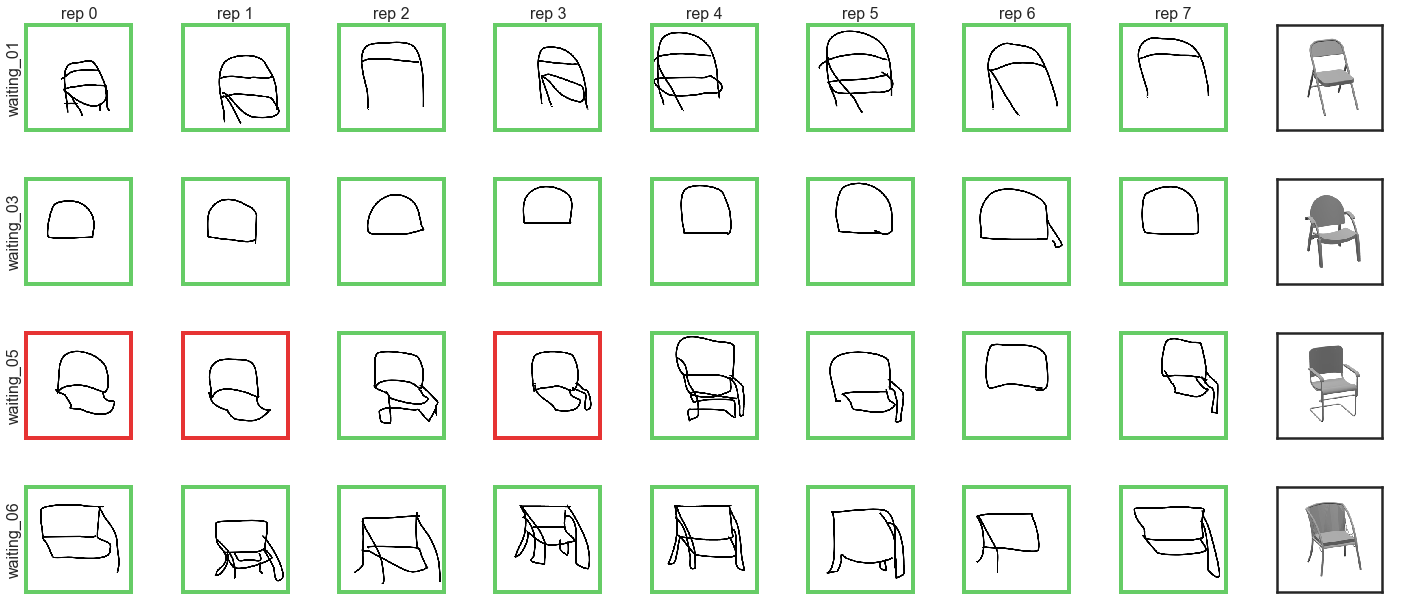

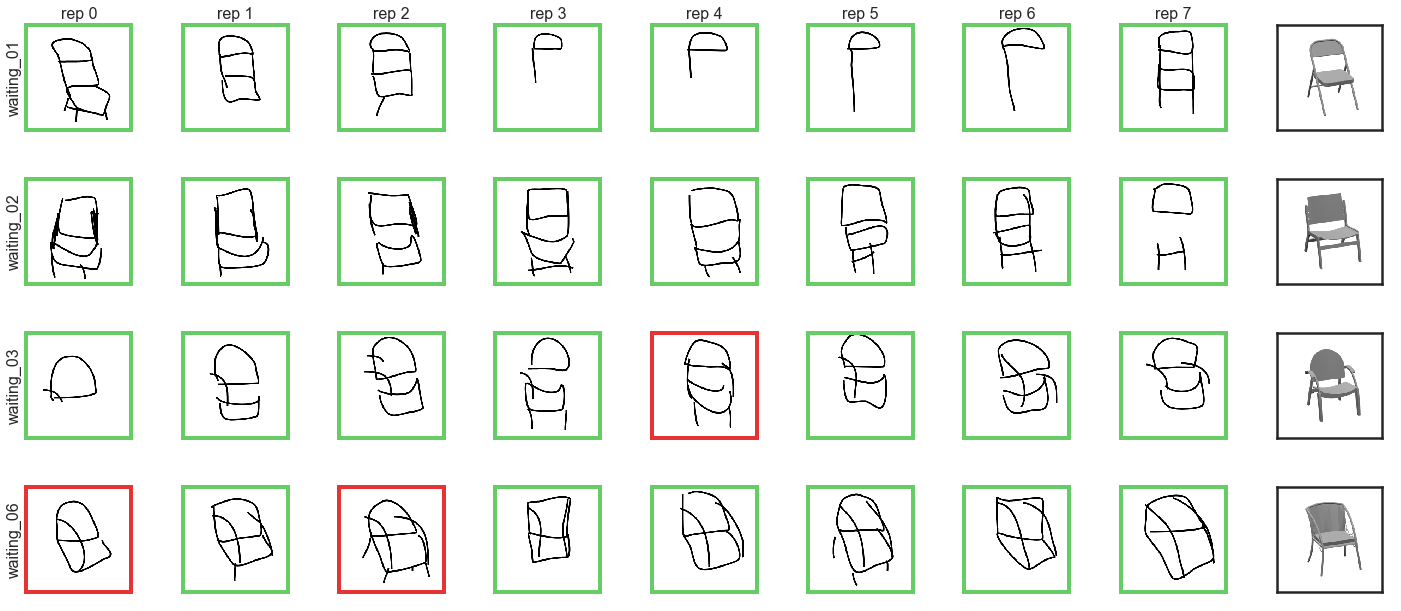

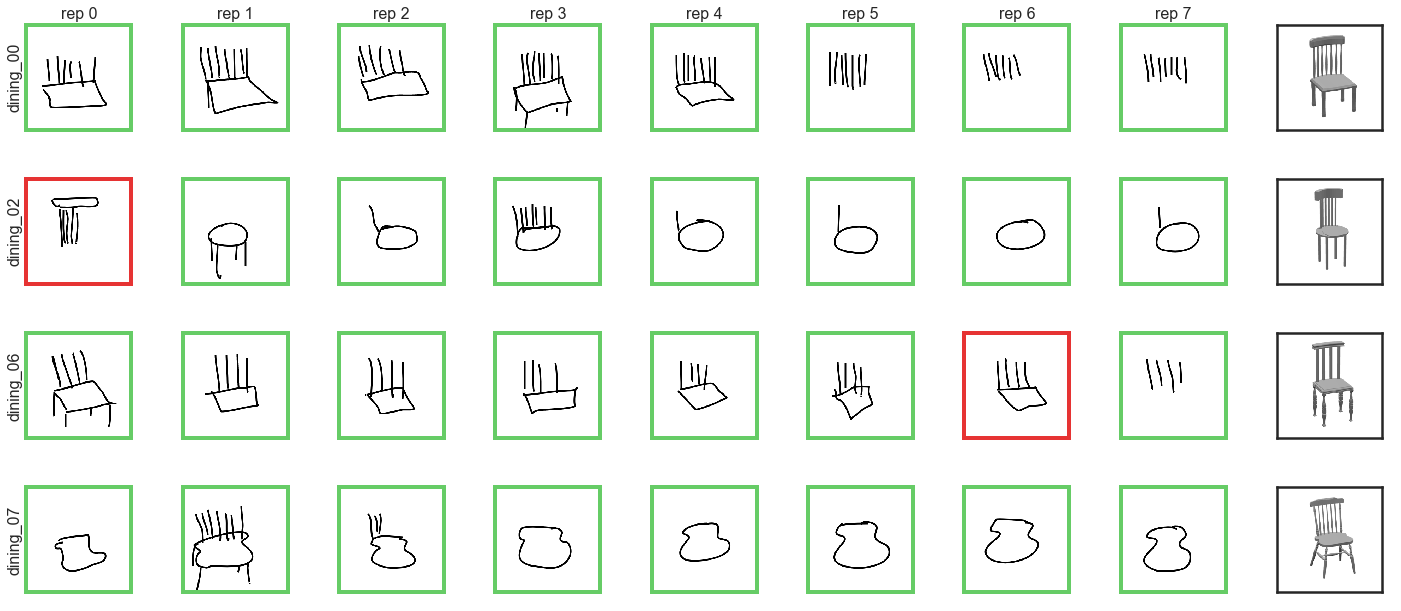

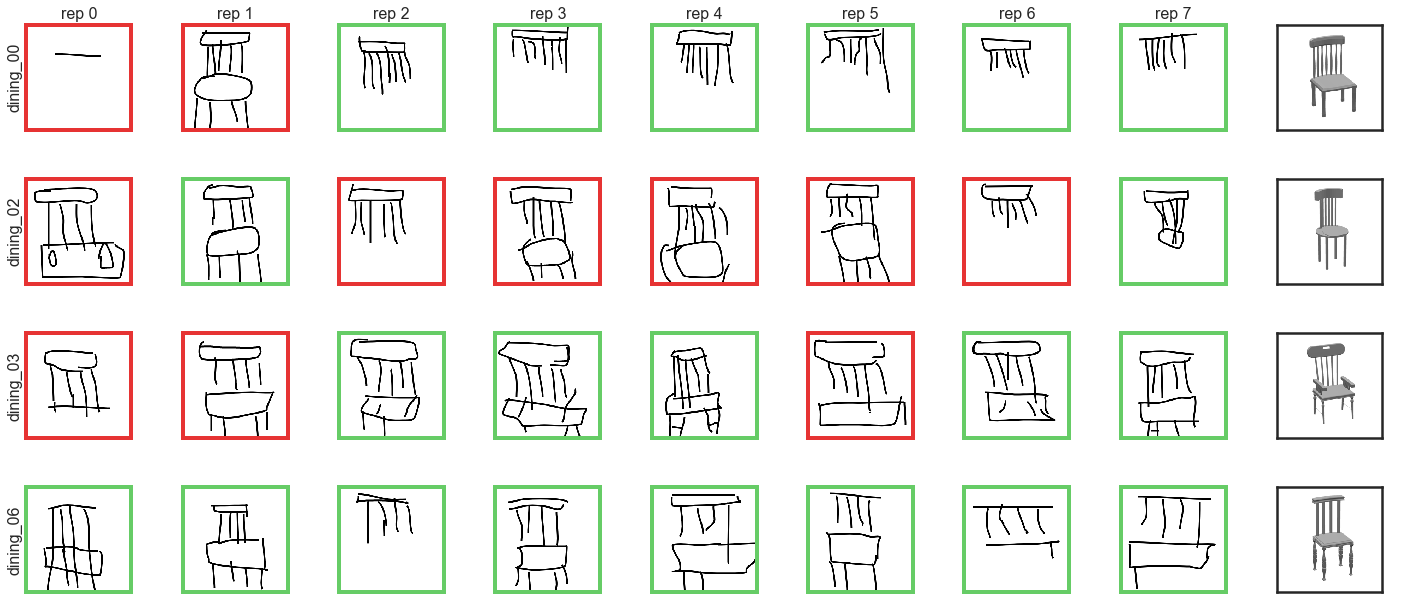

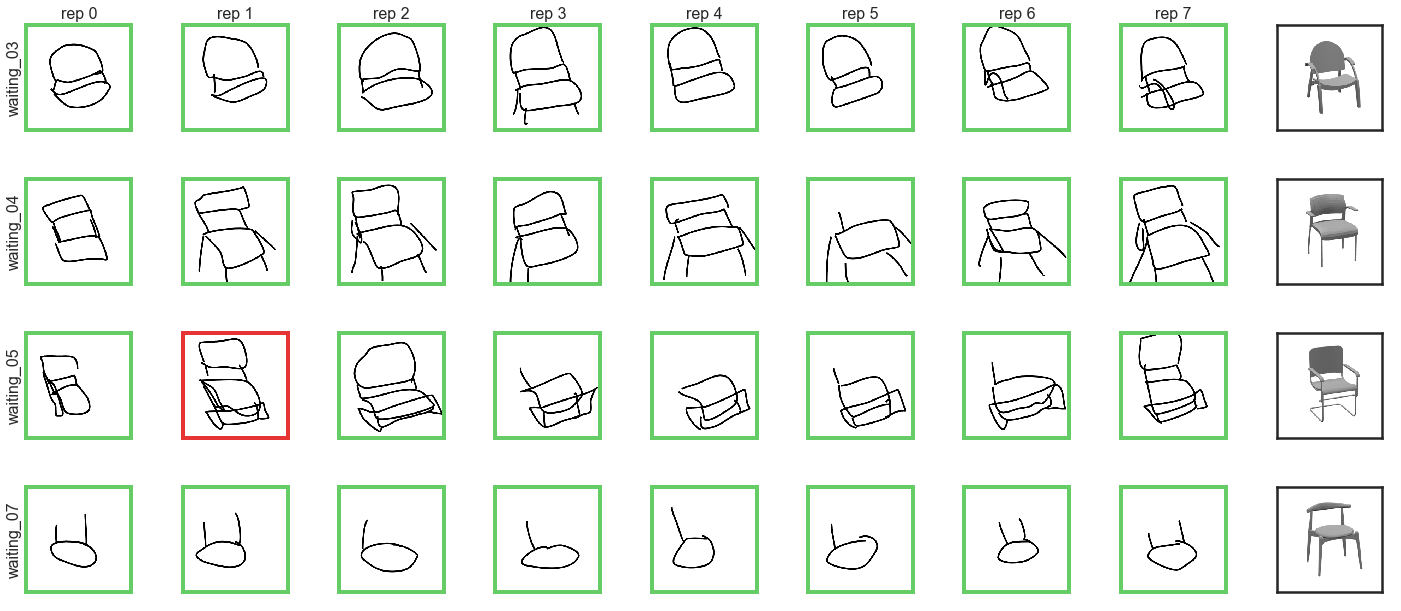

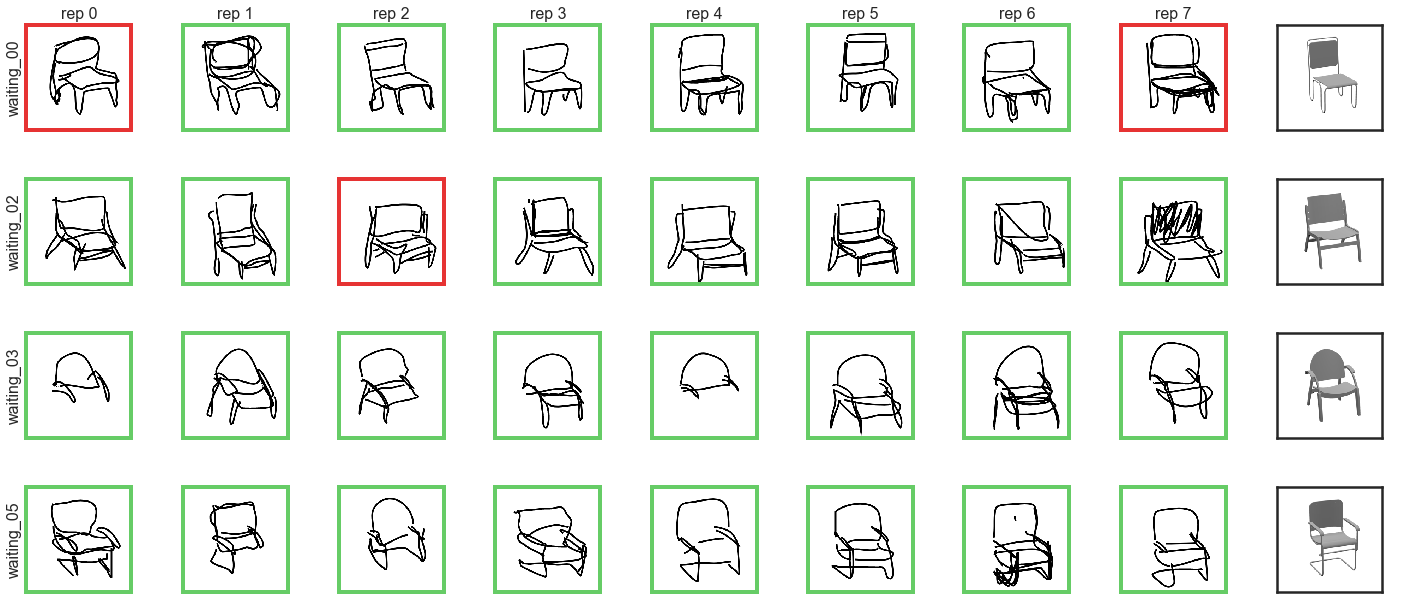

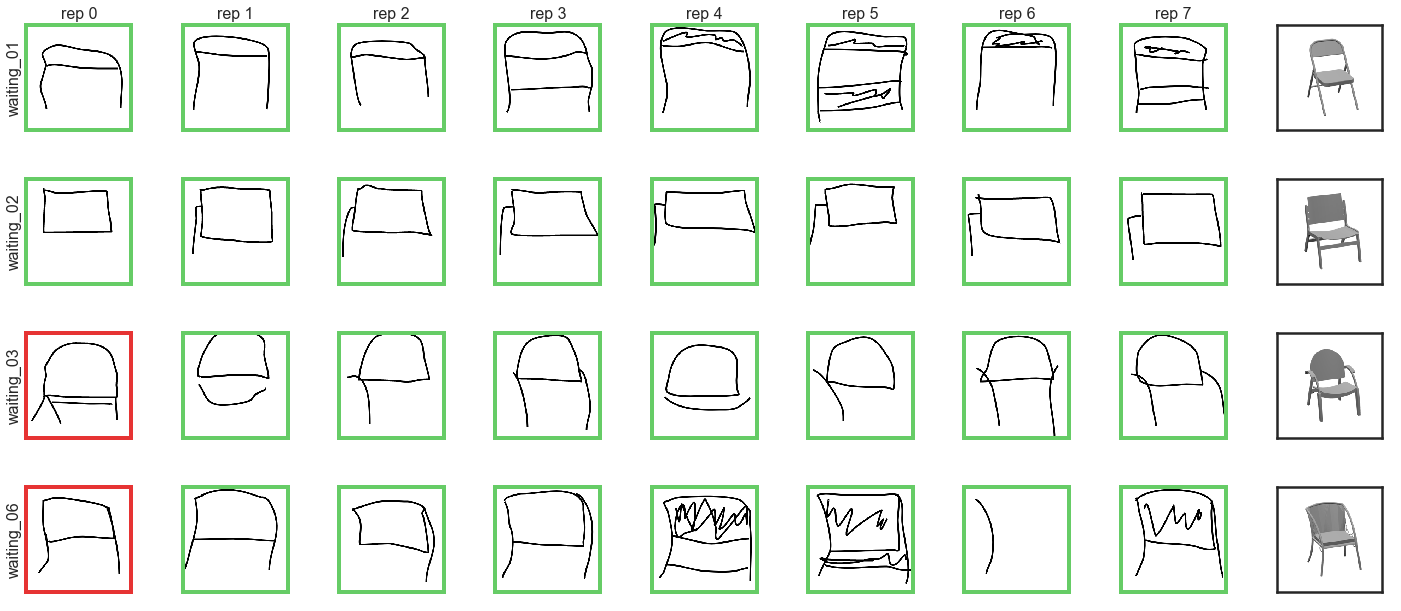

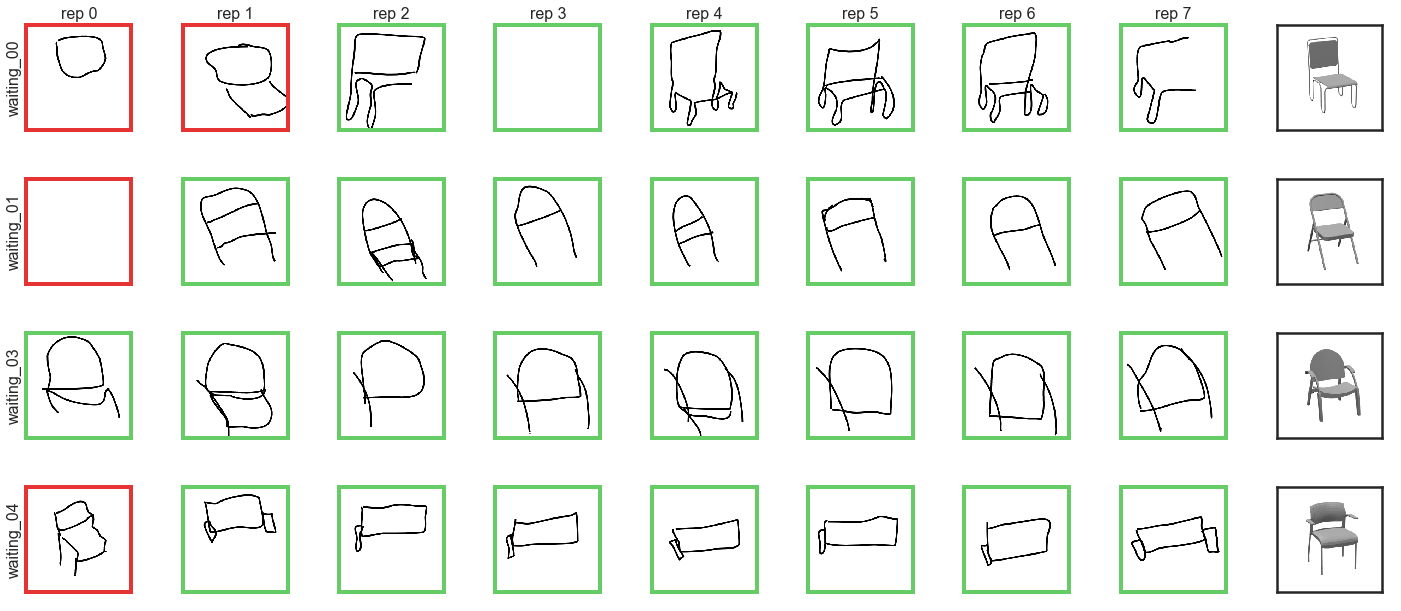

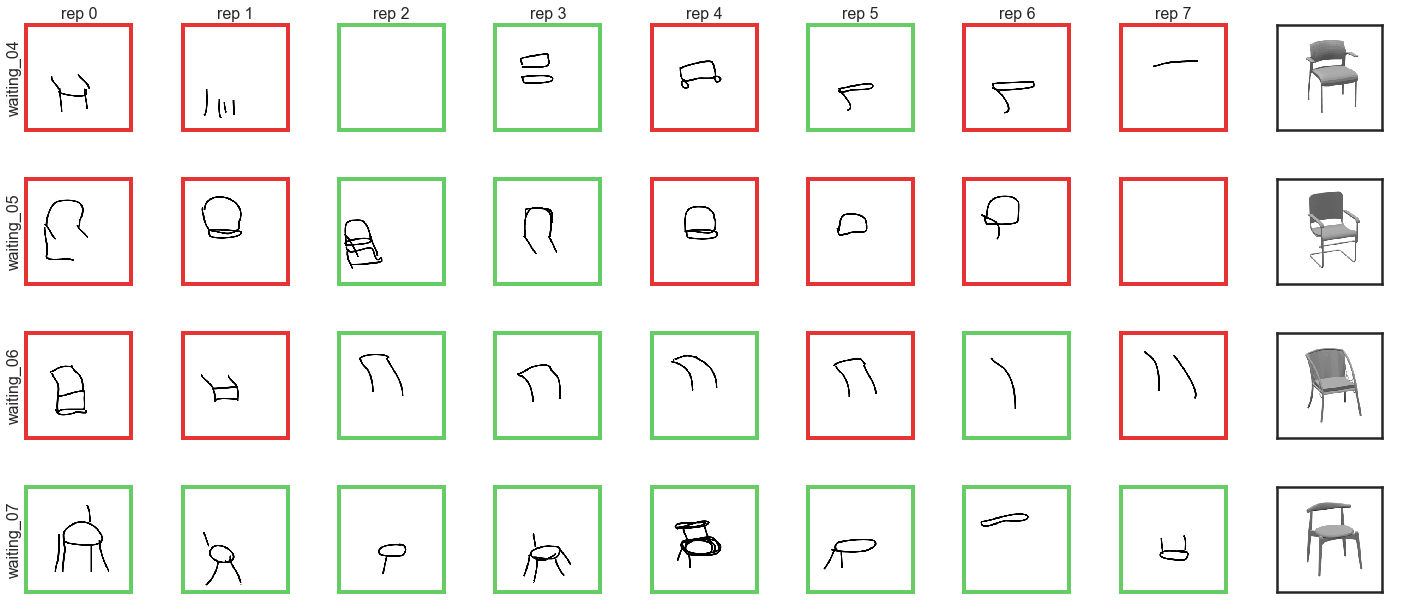

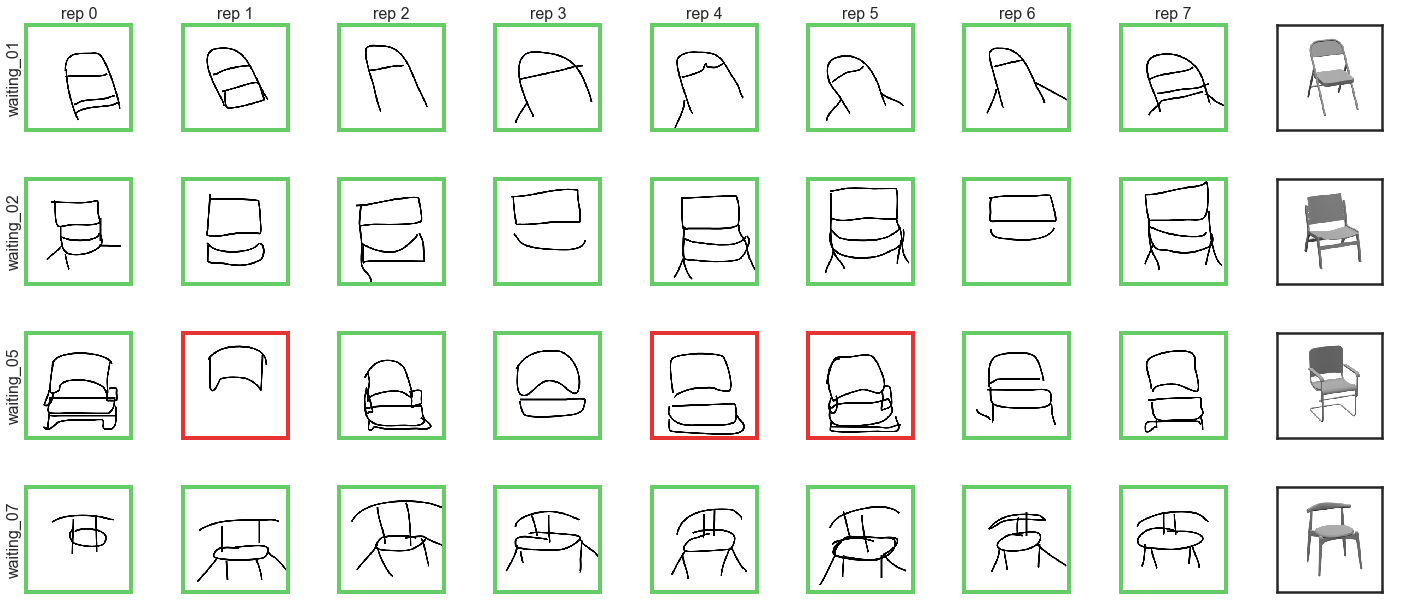

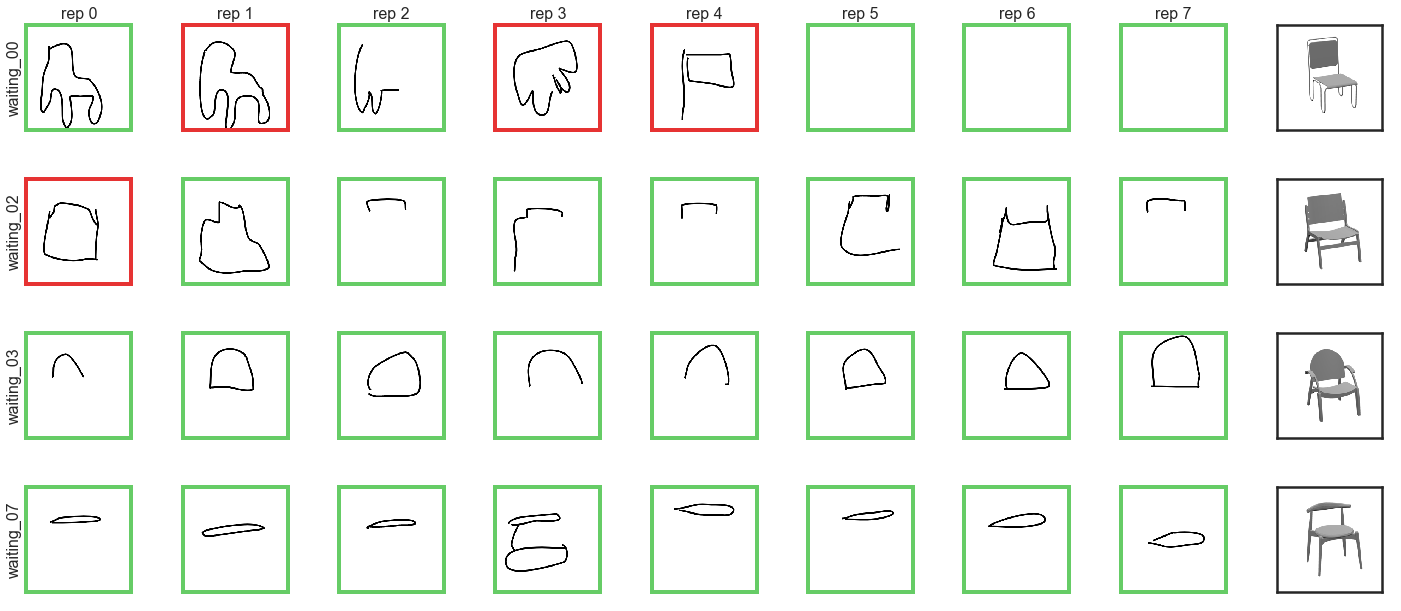

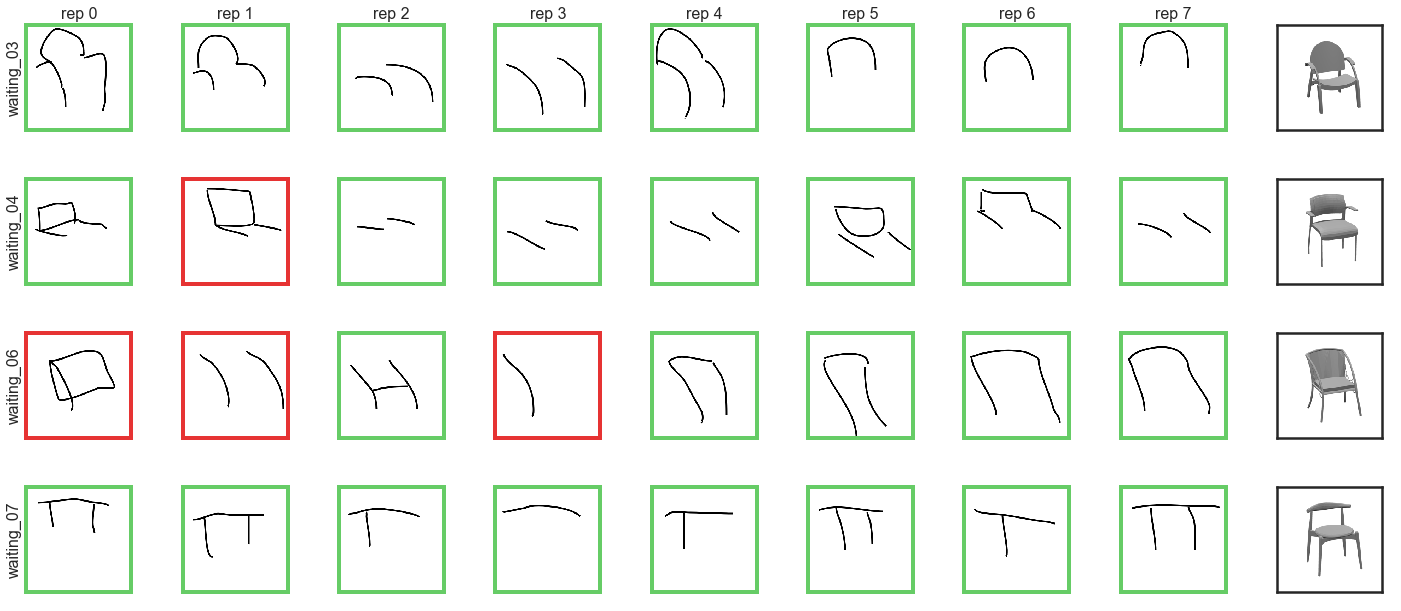

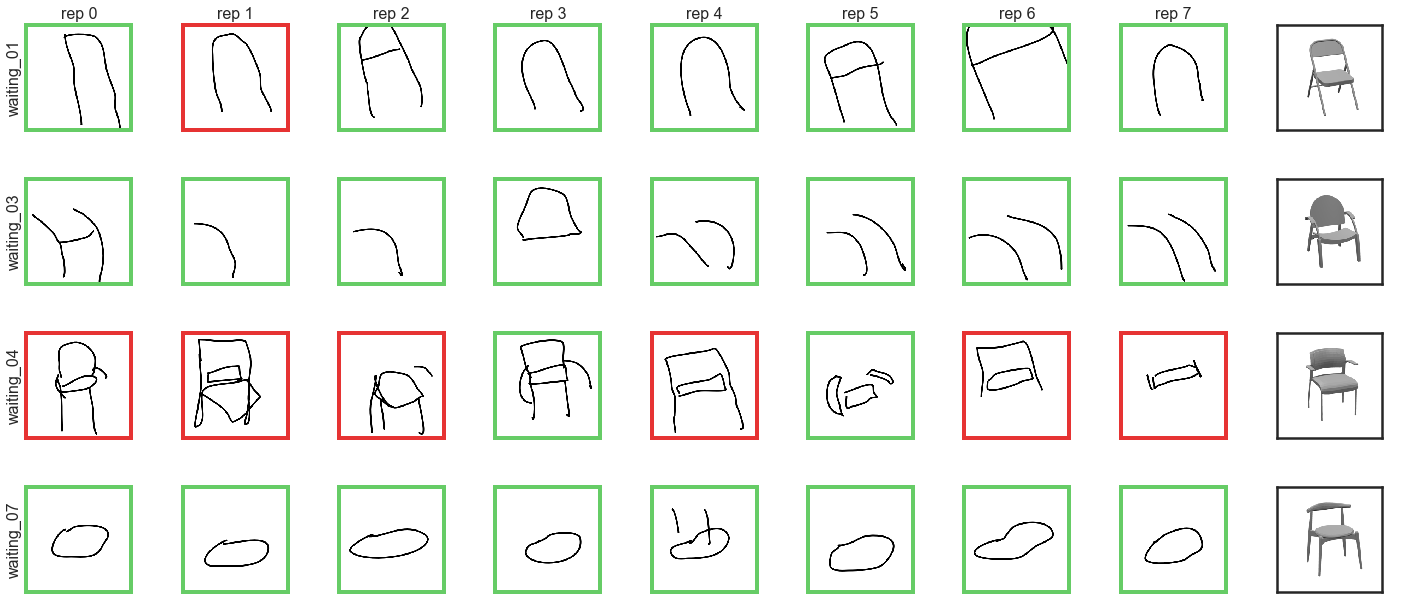

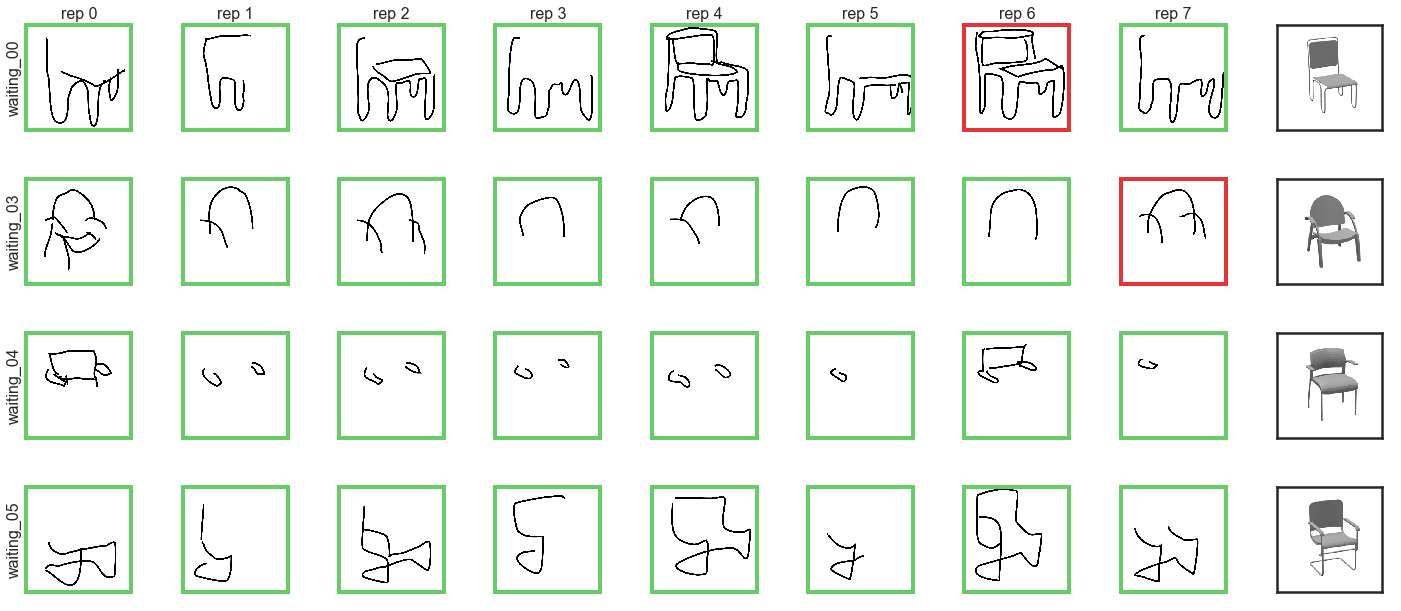

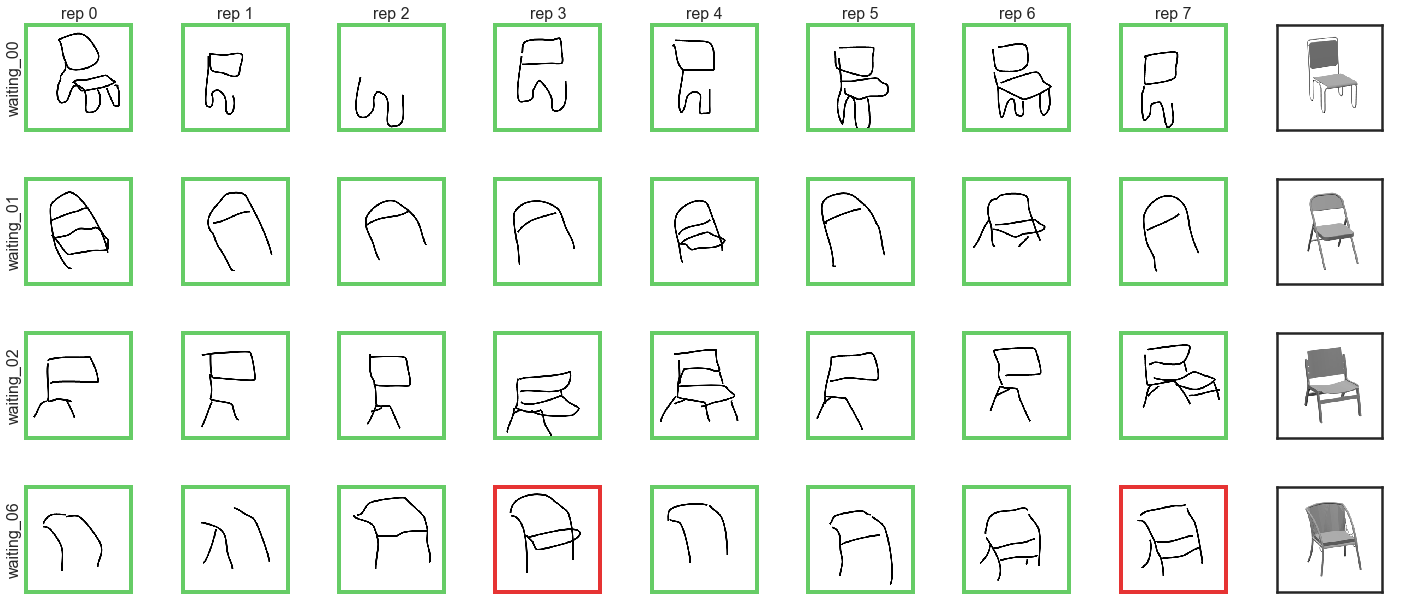

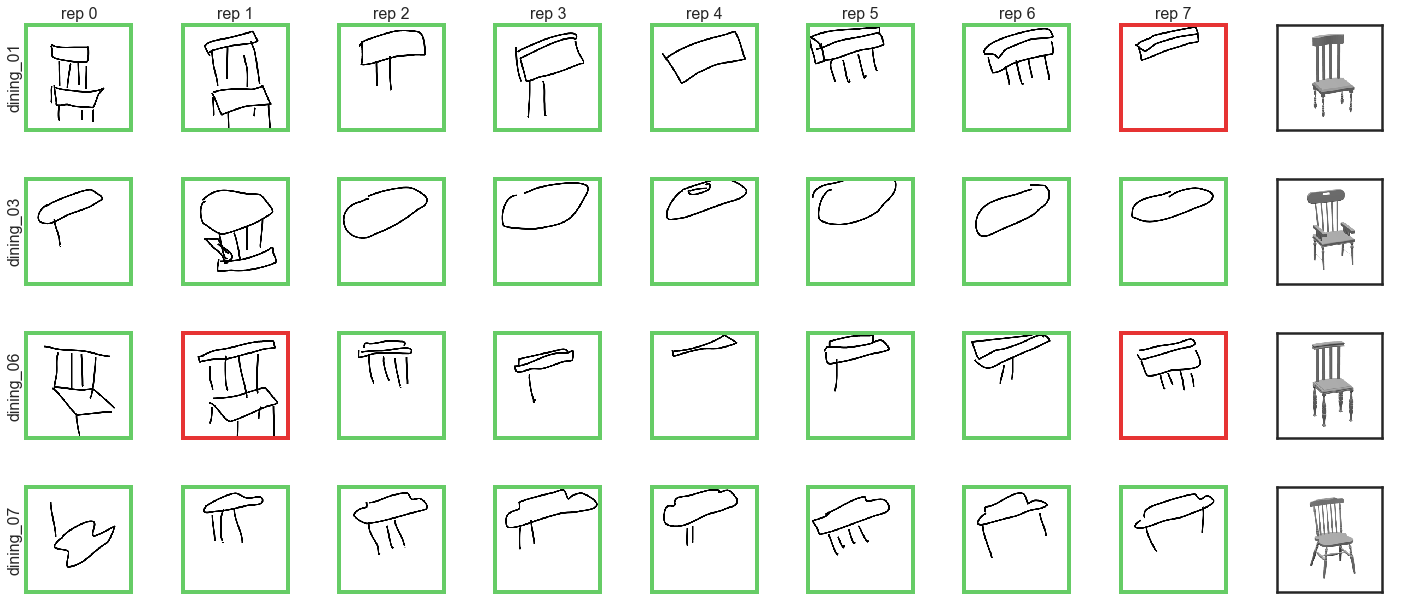

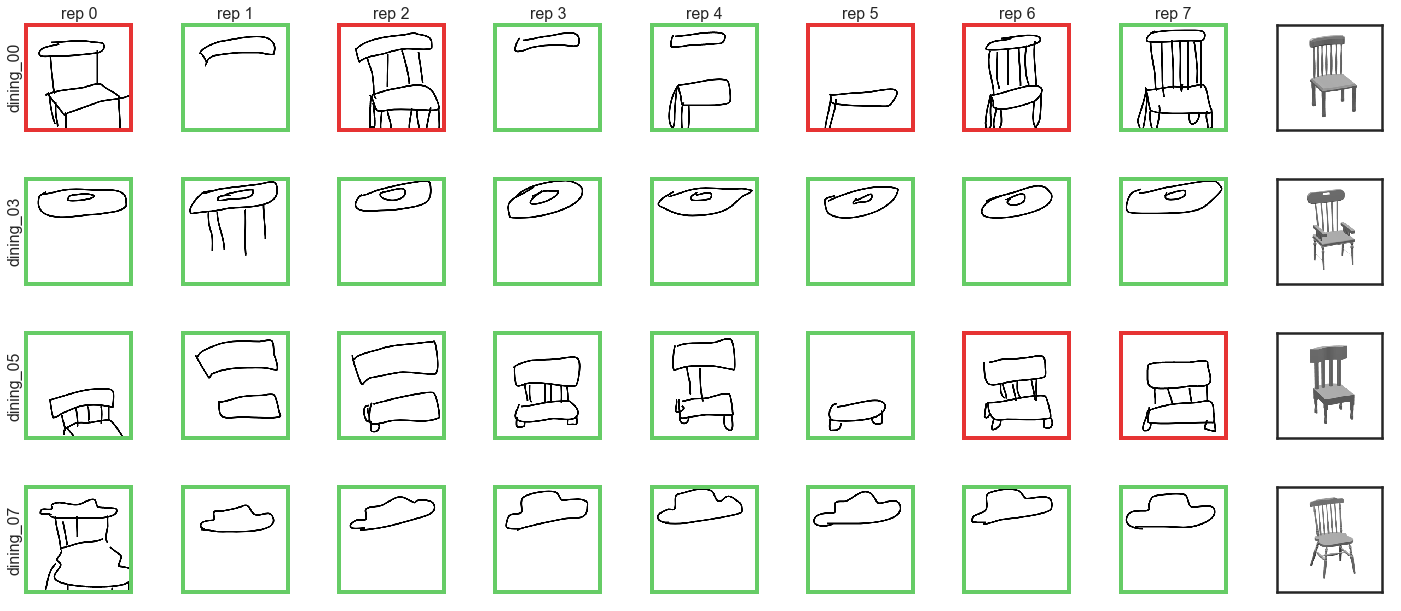

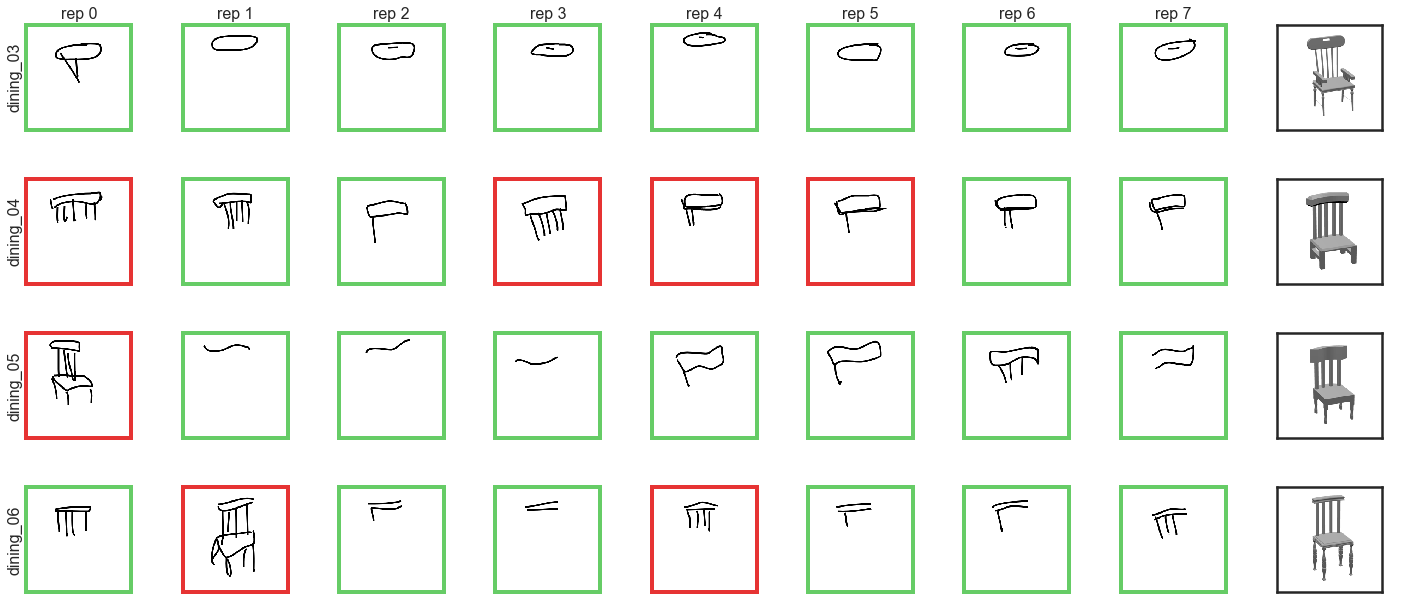

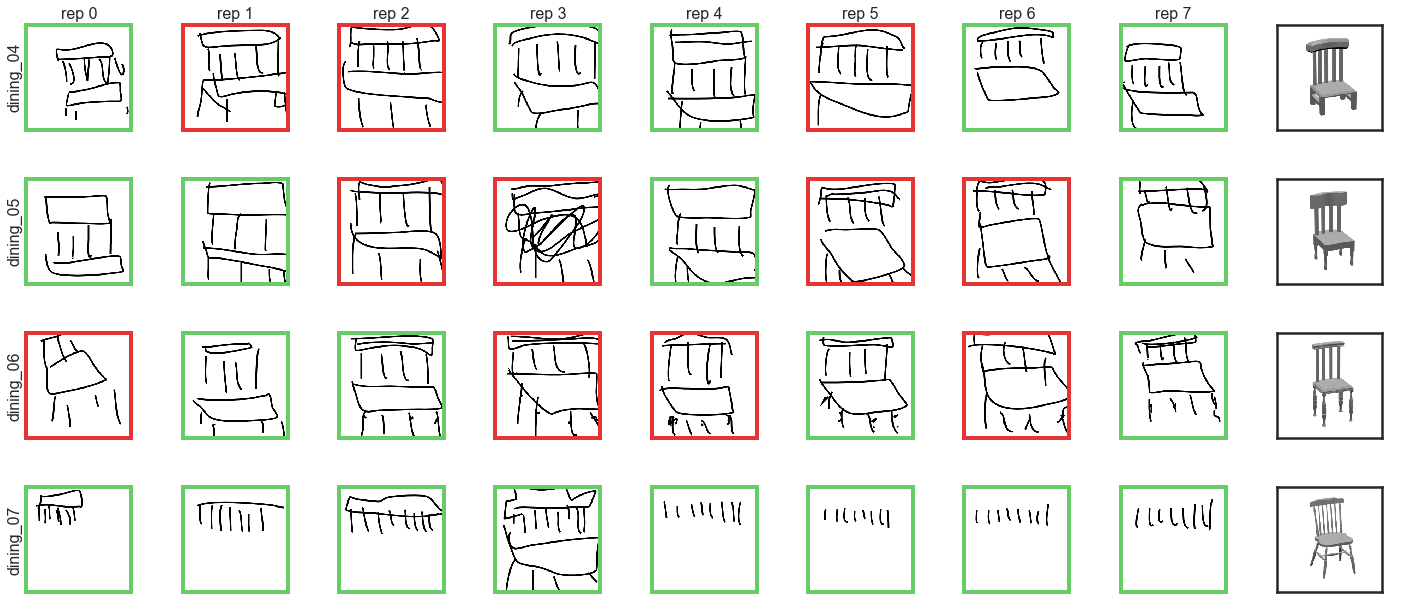

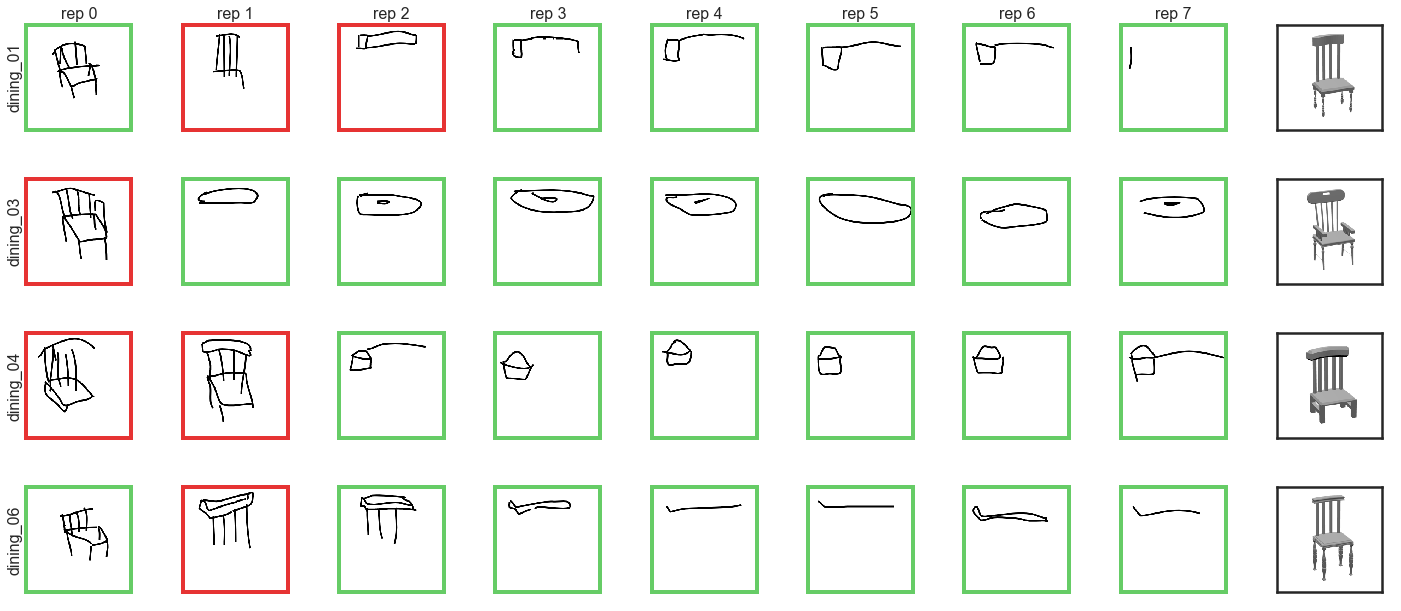

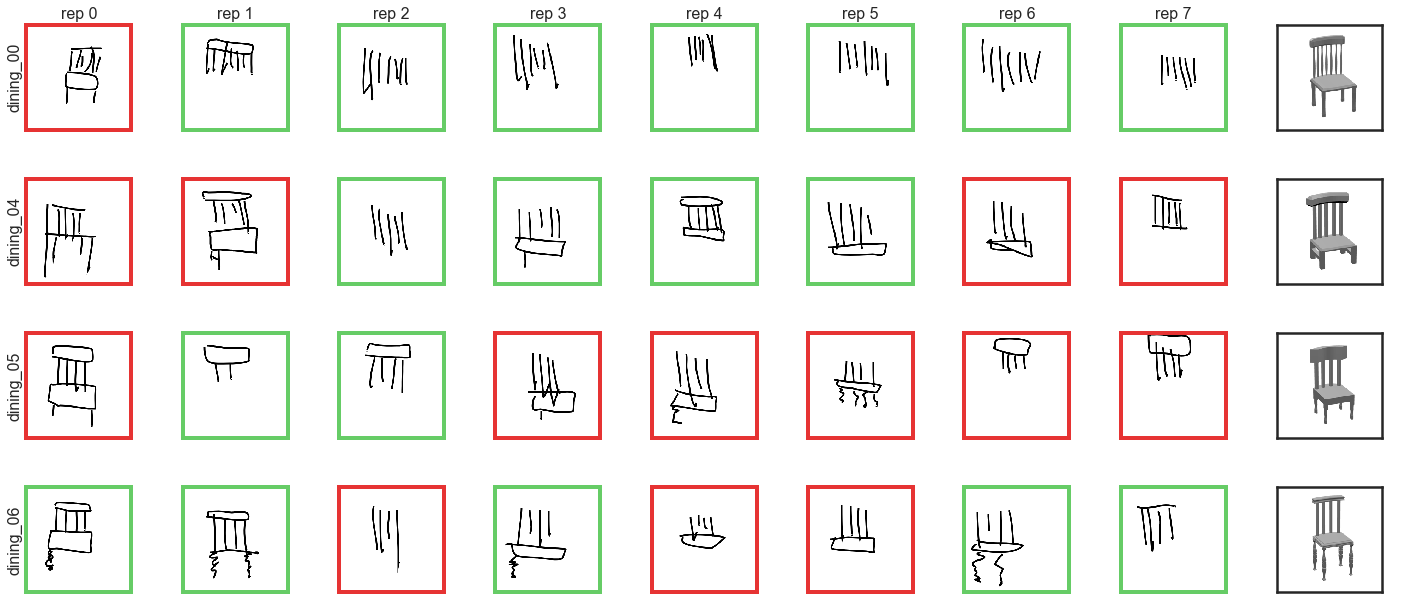

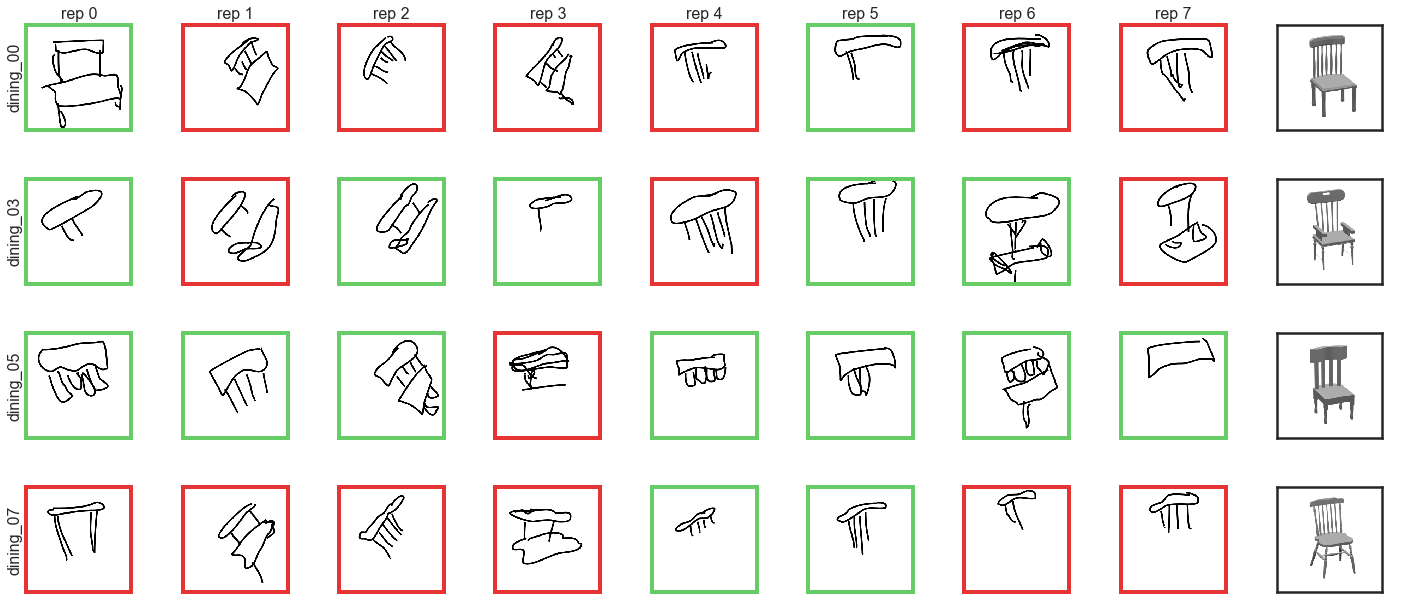

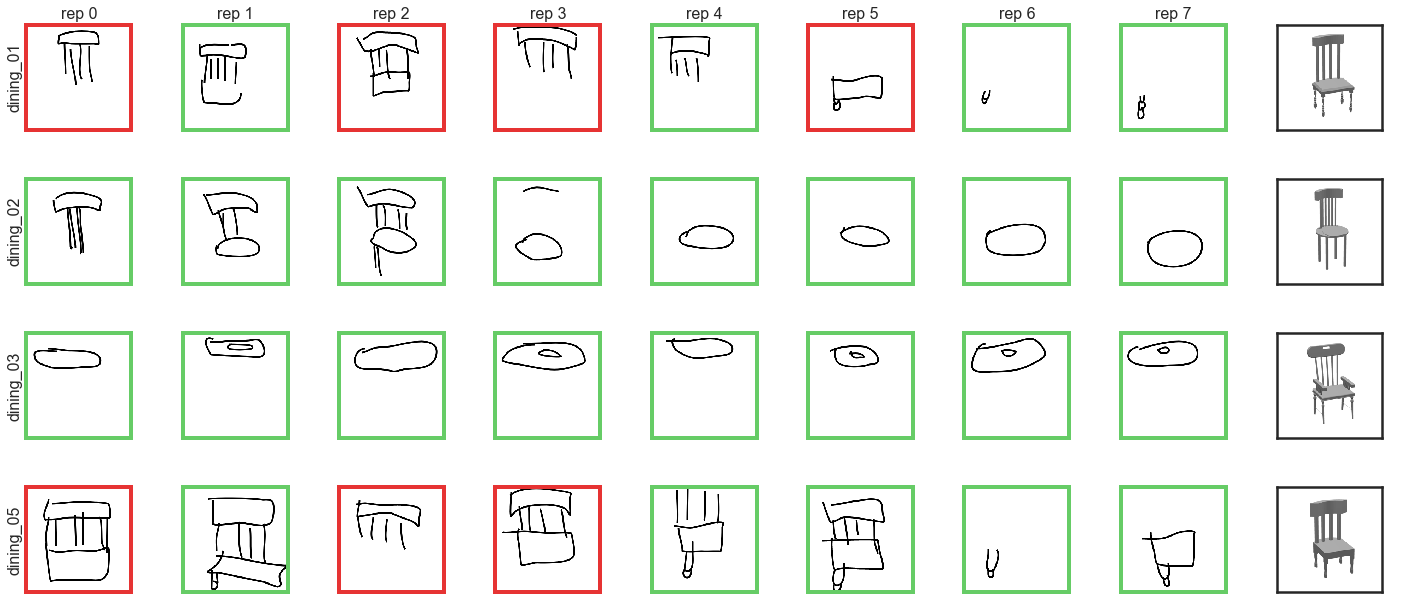

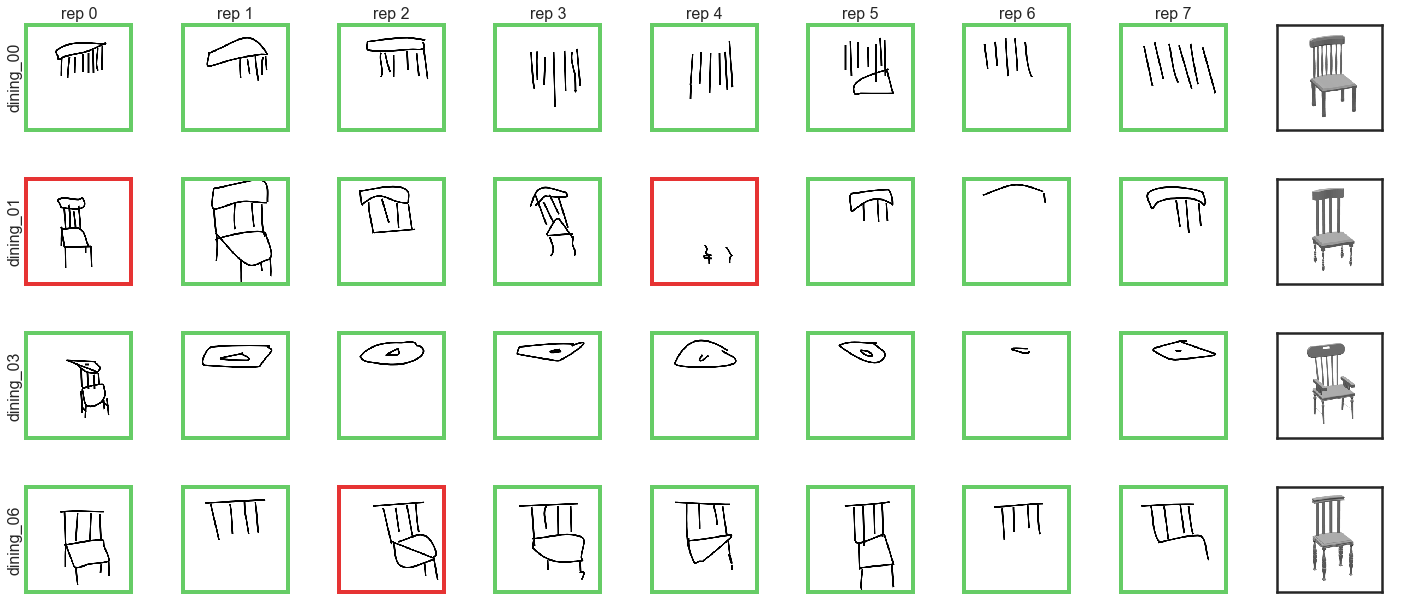

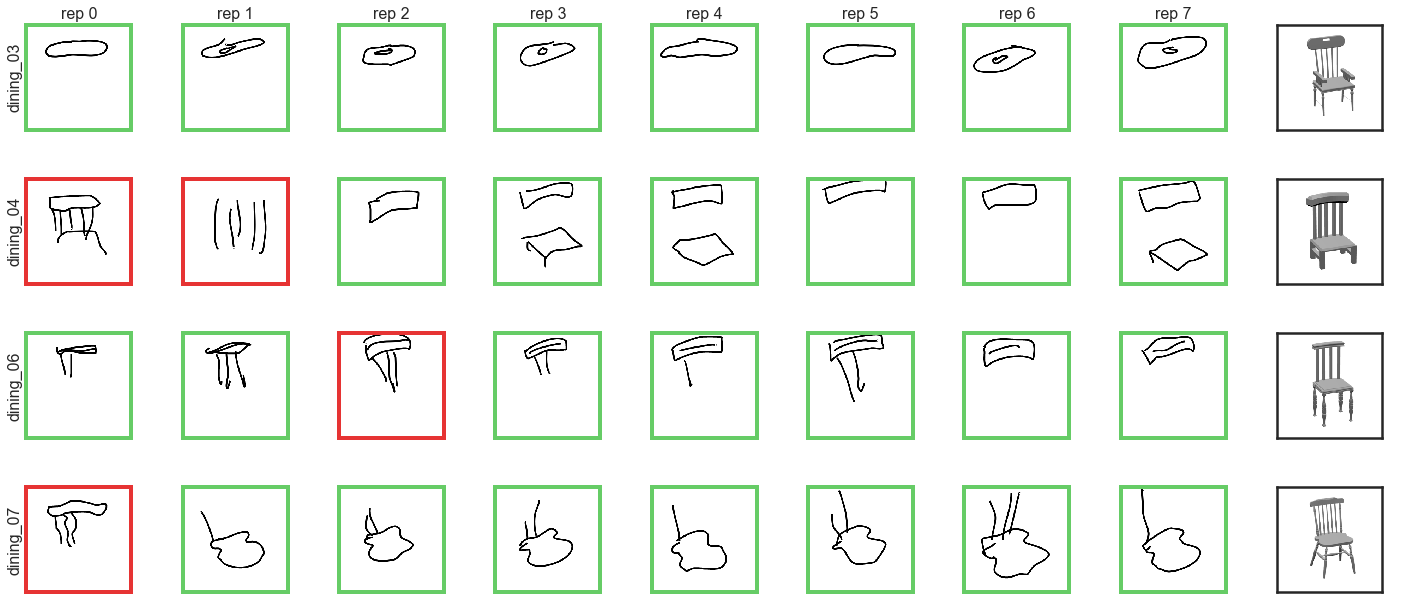

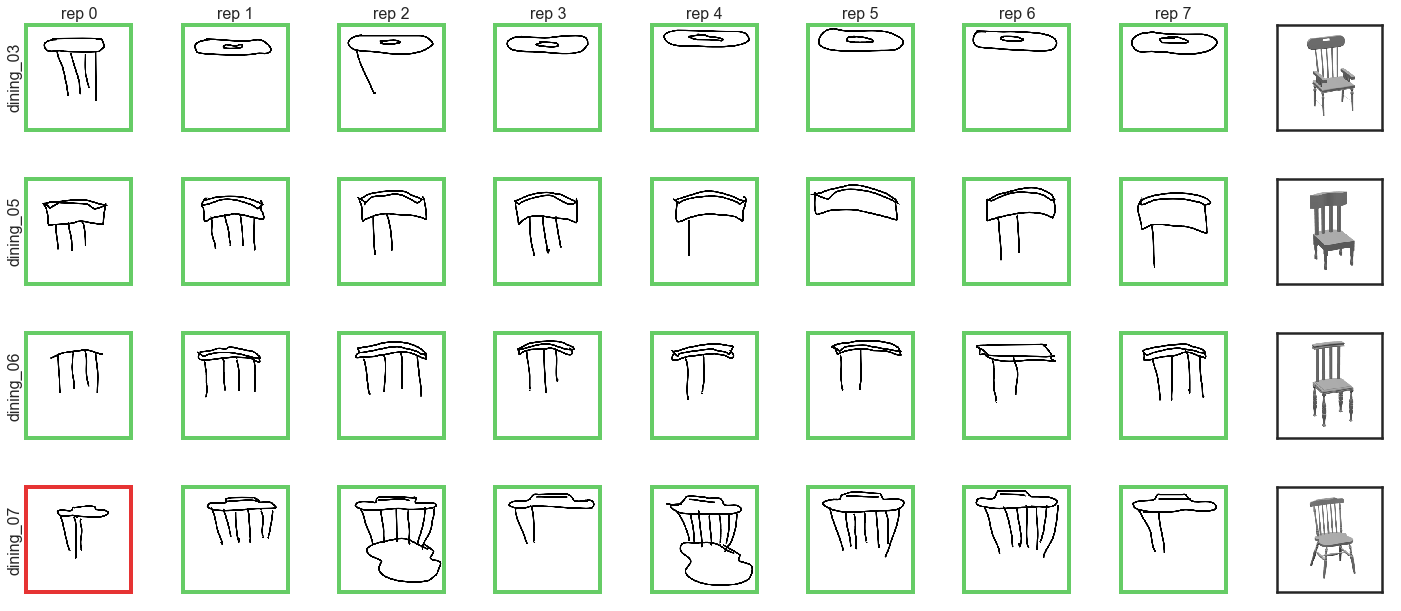

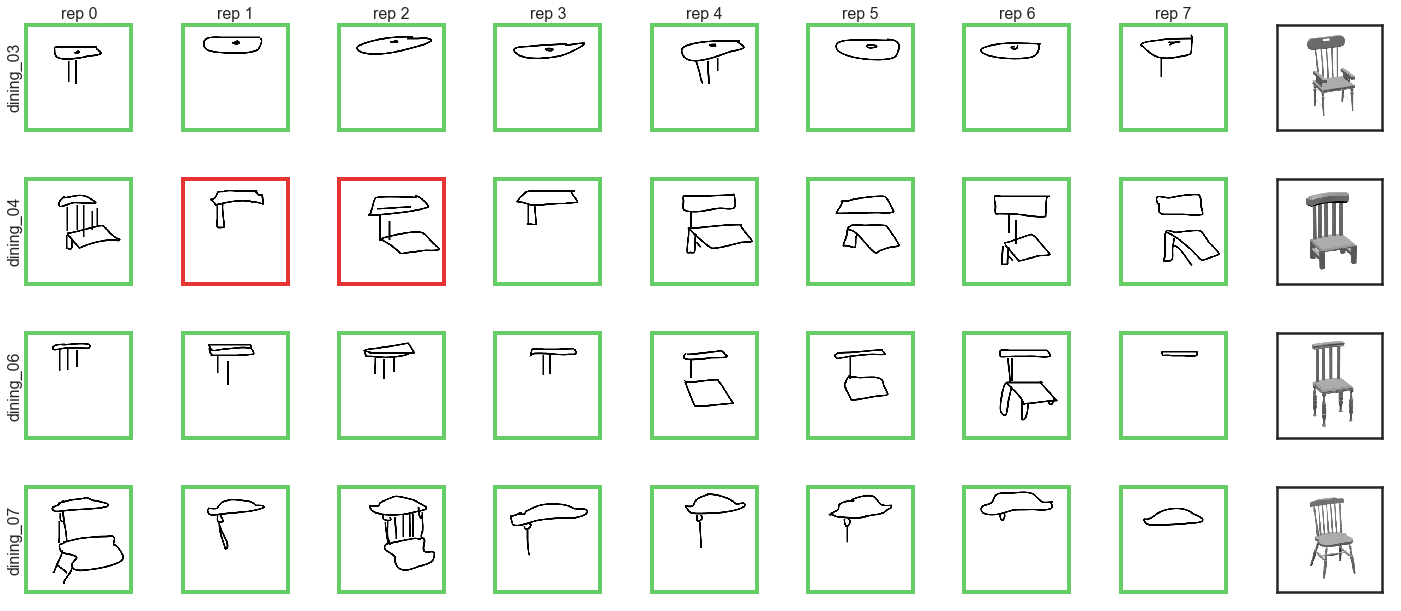

In [116]:
reload(h)
h.print_repeated_actual(D,
                                   _complete_games,
                                   4)

##### printing last sketch of control condition next to repeated sketches 

Printing out sketches from game: 0836-215b3490-cdf2-4a13-b55a-ea90f7b1903b
Printing out sketches from game: 8705-4970135a-e63c-4cd1-953f-d5850978a781
Printing out sketches from game: 0051-e13f6f0c-ae9b-4976-8fcd-870cdb75f63f
Printing out sketches from game: 9289-9e66fe1c-fc3d-4fc3-868f-ac6a2c7def6e
Printing out sketches from game: 0786-9d8492b6-e57d-4cb6-a44e-a79bccb681f4
Printing out sketches from game: 5598-e6b25d85-7c51-49f0-9529-c4c42d15b233
Printing out sketches from game: 6378-75ca9ee2-ed38-4434-b0bc-00c039f29b57
Printing out sketches from game: 7940-e30c3a20-dd99-4efc-ae92-f650a7f1d6e6
Printing out sketches from game: 1696-c4c60e8e-a818-42cf-8cef-9b5466d277a3
Printing out sketches from game: 9662-69da656f-884a-416f-a492-59c9f6a13a34


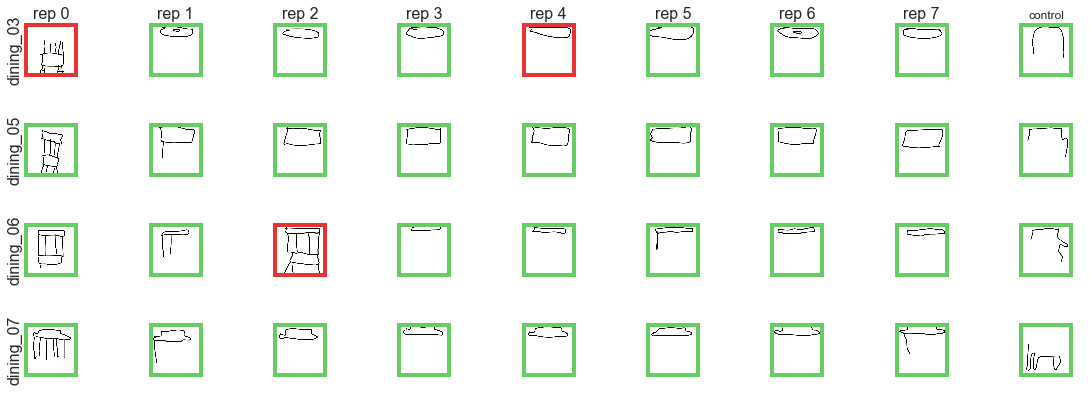

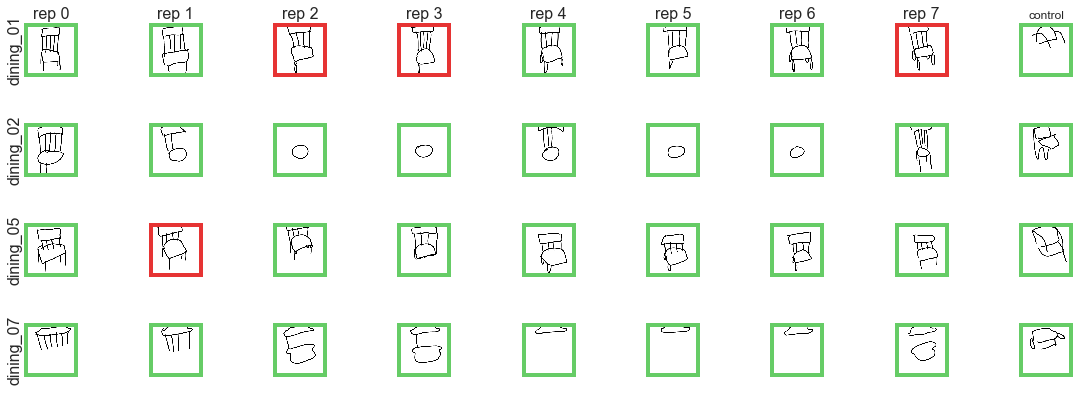

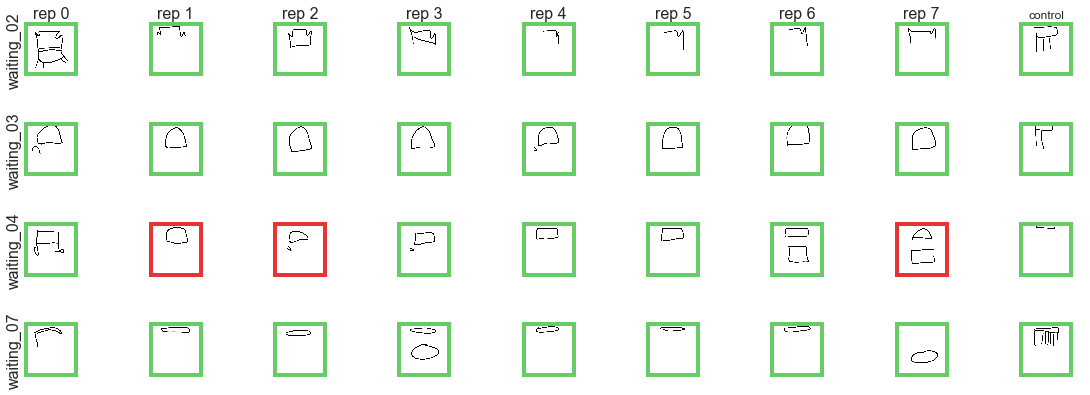

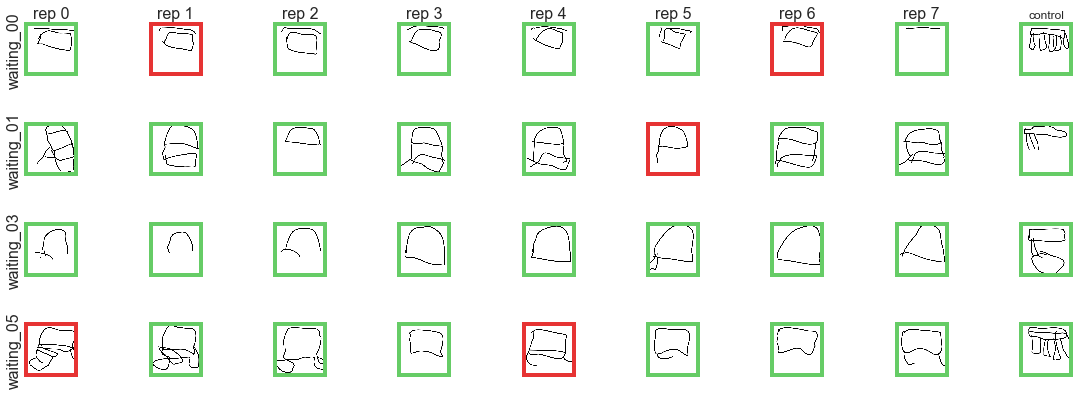

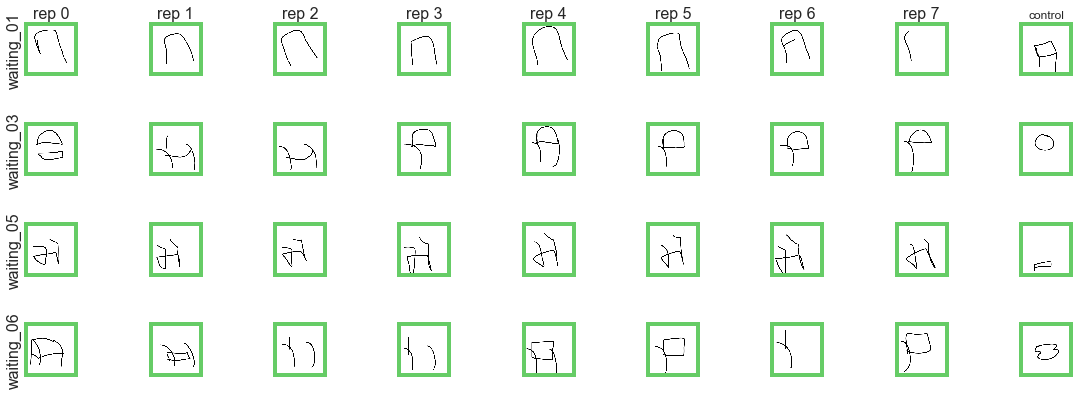

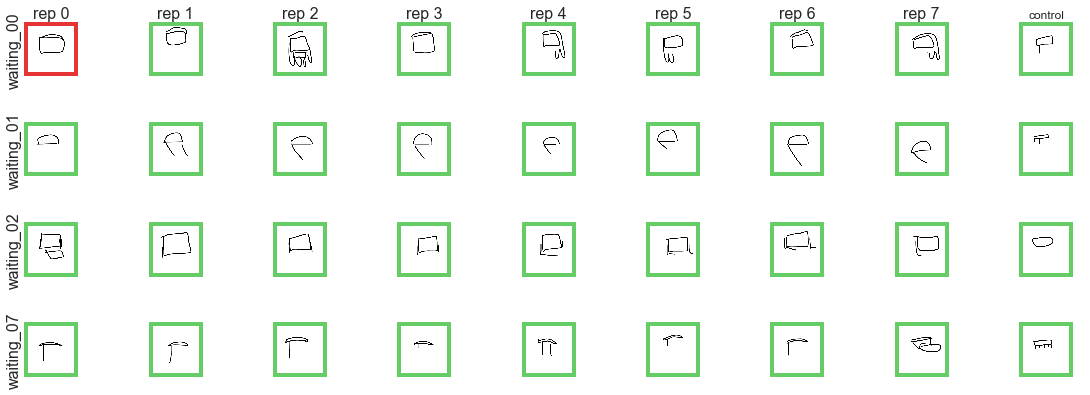

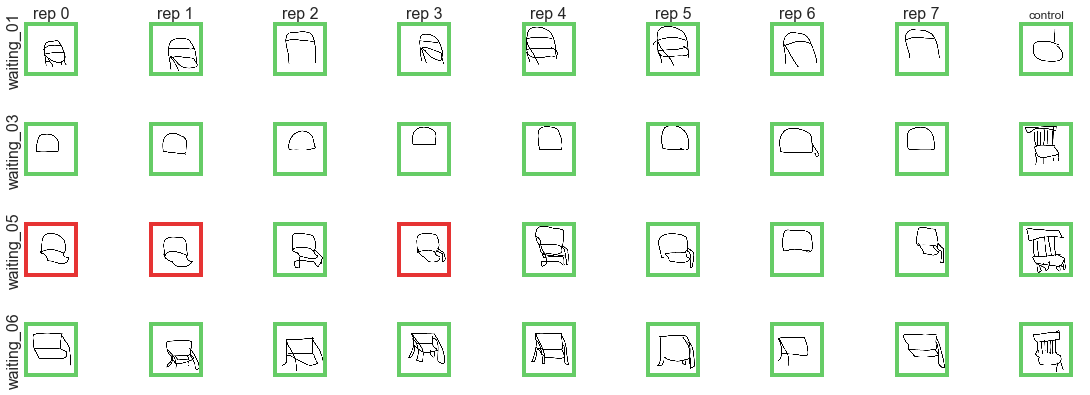

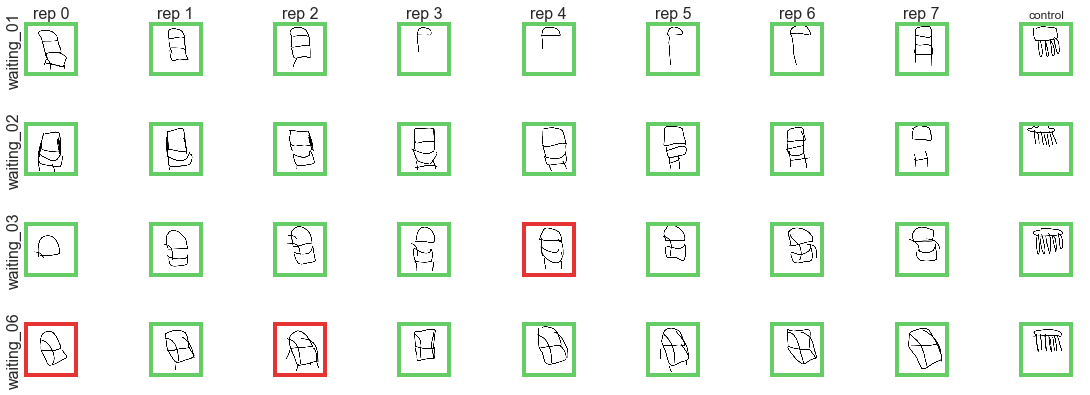

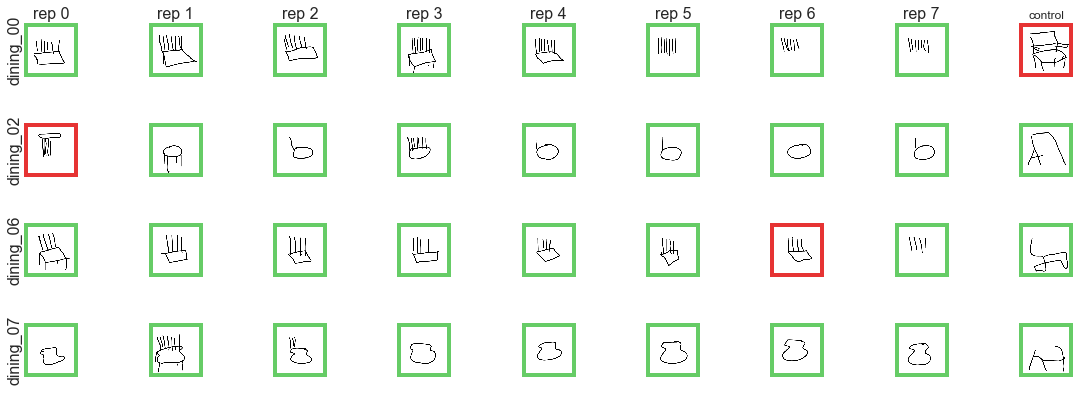

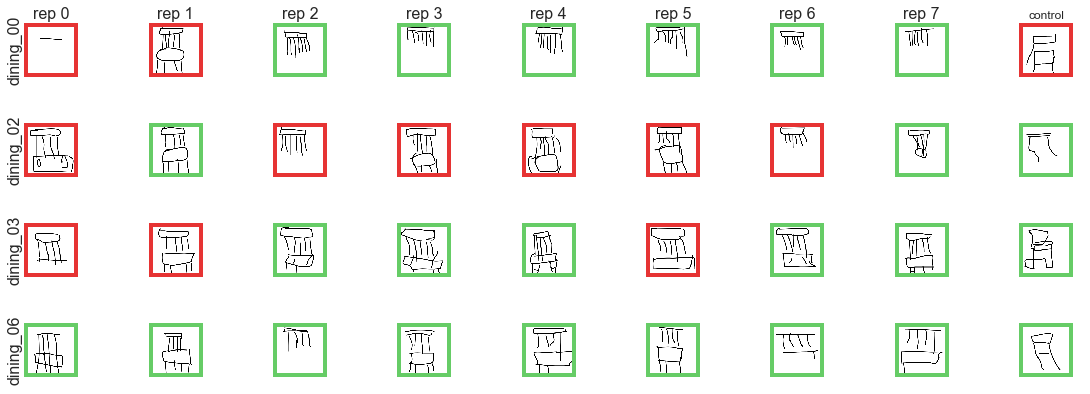

In [50]:
y = ['9790-3a0dd9df-cae0-4f97-95b4-93bf1d0bfd09'] ## broken png? 
_complete_games= [item for item in complete_games if item not in y]

reload(h)
h.print_repeated_control(D,
                                   _complete_games,
                                  4)